Libraries needed to run the code. This needs to be rerun when restarting the kernel.

In [1]:
from brian2 import *

import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy.special import erf

INFO       Cache size for target "cython": 4413 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\irene\.cython\brian_extensions" directory. [brian2]


# Quick overview of the model

The goal of the model is to make and simulate a small part of a cortical column, with which we can test E/I balance. We model a layer 4 and layer 3 and give layer 4 input via a thalamic layer:

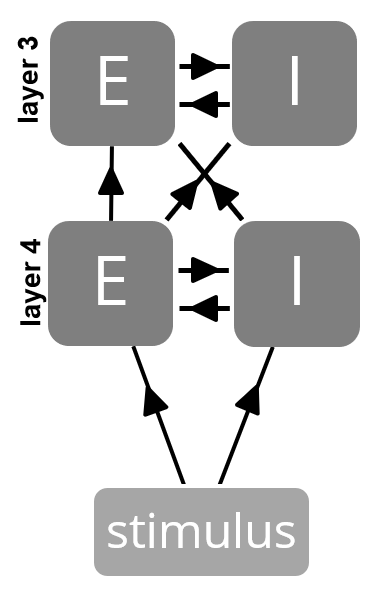

Later on, we can asses the synaptic input that layer 3 receives to analyse the E/I balance.

First we made a single regular spiking and fast spiking neuron. For this, we define some system parameters. The `defaultclock.dt` sets the timestep of the simulation and is standard 0.01 ms in Brian. The `simulation_duration` is the length of the simulation.

In [2]:
# System parameters
defaultclock.dt = 0.01*ms
simulation_duration = 800*ms

Then we set the parameters for the neuron. The values and neuron equations are taken from Pospischil, 2008 (DOI: 10.1007/s00422-008-0263-8) and are later fitted to data from experiments with rodents. The RS-specific parameters are labelled with `E_` in front, because the regular spiking neurons are also the excitatory neurons which we can see later on.

The conductances and capacitance are relative to the neuron surface.

## RS (excitatory) neuron

In [3]:
# Parameters for regular spiking neurons
E_gleak     = 1.05e-5 * siemens/(meter**2)*1e-4
E_Eleak     = -70.3 * mV
E_V_T       = -59 * mV
E_gNa       = 0.086 * siemens/(meter**2)*1e-4
E_gK        = 0.006 * siemens/(meter**2)*1e-4
E_gM        = 15e-5 * siemens/(meter**2)*1e-4
E_tau_max_M = 808 * ms

Cm        = 1 * ufarad/(meter**2) * 1e-4
EK =   -90 * mV
ENa =  50 * mV
E_M = -100 * mV

Now we introduce the neuron equations. These are Hodgkin-Huxley type equations and are also taken from Pospischil, 2008. We use Na, fast and slow K current from this and the leak current is based on the leak current model from Dynasim. The input for the model is current: `I_app`.

In [4]:
# RS neuron equations (for single neuron)
eqs_HH_RS_no_synapes = '''
I = IK + INa + IM + I_leak+ I_app   : amp * meter**-2
dv/dt = I/Cm  : volt 

I_app : amp * meter**-2

dn/dt = alpha_n * (1-n) - beta_n * n: 1
dm/dt = alpha_m * (1-m) - beta_m * m : 1
dh/dt = alpha_h * (1-h) - beta_h * h: 1
dp/dt = (p_inf - p)/tau_p : 1

alpha_n = -0.0320/mV*(v-E_V_T-15.0*mV) / (exp( -(v-E_V_T - 15.0*mV)/(5.0*mV)) - 1) * 1/msecond : Hz     
beta_n = 0.50 * exp( -(v-E_V_T - 10.0*mV)/(40.0*mV))*1/msecond : Hz
alpha_m =  -0.32/mV*(v-E_V_T-13.*mV) / (exp(-(v-E_V_T-13.*mV)/(4.*mV))-1)*1/msecond:Hz
beta_m = ( 0.28/mV * ((v-E_V_T-40.*mV))) / (exp((v-E_V_T-40.*mV)/(5.*mV))-1 ) *1/msecond : Hz
alpha_h = 0.128 * exp(-(v-E_V_T-17.*mV)/(18.*mV)) *1/msecond : Hz
beta_h = 4./(1.+exp(-(v-E_V_T-40.*mV)/(5.*mV))) *1/msecond : Hz
p_inf = 1 / (1.+exp(-(v+35.*mV)/(10.*mV))) : 1
tau_p = E_tau_max_M /( (3.3*exp((v+35.*mV)/(20.*mV)) + exp(-(v+35.*mV)/(20.*mV)))) : second 

IK    = -E_gK * n**4 *(v-EK) : amp * meter**-2
INa   = -E_gNa*m**3*h*(v-ENa)   : amp * meter**-2
IM    = -E_gM *p *(v-E_M)  : amp * meter**-2

I_leak = -E_gleak*(v-E_Eleak): amp * meter**-2
'''

Now we make the class in Brian2 that represents the neuron. The `treshold` and `refractory` functions are there so Brian can trace when action potentials happen. I use `method='exponential_euler'`, because this is the fastest for HH type neurons. We also set an initial value for the membrane potential, all values are otherwise standard 0 in the beginning.

In [5]:
# Make the neurongroup (single neuron)
single_RS_neuron = NeuronGroup(1, eqs_HH_RS_no_synapes, 
                               threshold='v > 40*mV', refractory='v > 40*mV', 
                               method='exponential_euler')

# Set initial conditions for V
initial_values = {'v':-65*mV}
single_RS_neuron.set_states(initial_values)

We add statemonitors to trace the membrane potential and stimulus and a spikemonitor so we can plot the action potentials later on.

In [6]:
# Monitor the system
statemon = StateMonitor(single_RS_neuron, ('v', 'I_app'), record=True)
spikemon = SpikeMonitor(single_RS_neuron, variables='v')

In [7]:
store() #store the network so it can be rerun later for the rheobase current check

The single RS neuron will be stimulated with a pulse current input for 50 ms and without stimulus before and after that.

In [4]:
# Running the simulation
injected_current = 140e-12*amp/meter**2

# Set the interval for the stimulation
begin_time = 20*ms # here there will be no stimulation
stim_time = 100*ms
end_time = 80*ms # to see the aftermath
sim_time = begin_time + stim_time + end_time

In [9]:
# Run each interval with the correct amount of current, at first
# it is standard 0 A/m^2
run(begin_time)
single_RS_neuron.I_app = injected_current
run(stim_time)
single_RS_neuron.I_app = 0*amp/(meter**2)
run(end_time)

Let's plot it now: the input current and what happened to the membrane potential because of it:

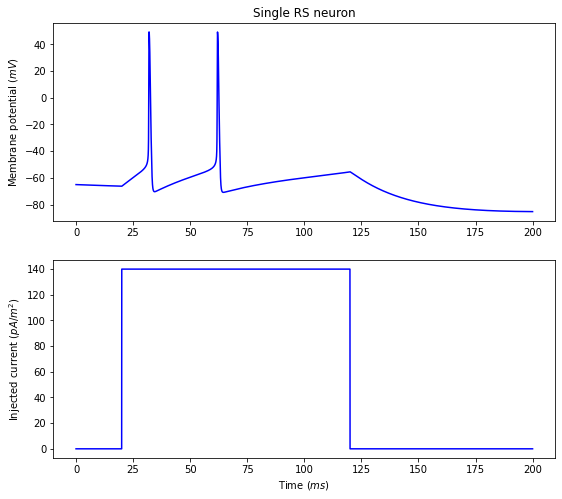

In [10]:
# Visualize
figure(figsize=(9, 8))

subplot(2,1,1)
title('Single RS neuron')
plot(statemon.t/ms, statemon.v[0]/mV, '-b') 
ylabel('Membrane potential ($mV$)')

subplot(2,1,2)
plot(statemon.t/ms, statemon.I_app[0]/(1e-12*amp*meter**-2), '-b')
ylabel('Injected current ($pA/m^2$)')
xlabel('Time ($ms$)')

show()

We can also see what the rheobase current is by adjusting the stimulus:

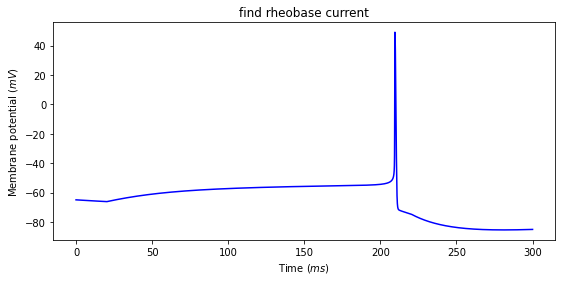

In [11]:
# restore it first, otherwise previous input will be saved als
restore()

# change this value to find the lowest value that will still cause an AP
test_current = 29.4565e-12*amp/meter**2

run(begin_time)
single_RS_neuron.I_app = test_current
run(stim_time*2)
single_RS_neuron.I_app = 0*amp/(meter**2)
run(end_time)

# plot
figure(figsize=(9, 4))

title('find rheobase current')
plot(statemon.t/ms, statemon.v[0]/mV, '-b') 
ylabel('Membrane potential ($mV$)')
xlabel('Time ($ms$)')

show()

The rheobase current is somewhere around 30 pA/m^2 (different now then with surface scaling), but the value depends on how long the neuron is stimulated (longer stimulation can allow lower stimulus).

## FS (inhibitory) neuron

Time to implement a fast spiking (inhibitory) neuron too!

These parameters and equations are also from Pospischil, 2008 and later adjusted by fitting; the FS specific parameters are pre-labelled with `I_`.

In [5]:
# Parameters for fast spiking neurons
I_gleak     = 3.8e-5* siemens/(meter**2)*1e-4
I_Eleak     = -70.4 *mV
I_gNa       = 0.078 * siemens/(meter**2)*1e-4
I_V_T       = -58*mV
I_gK        = 0.0039 * siemens/(meter**2)*1e-4
I_gM        = 5e-5 * siemens/(meter**2)*1e-4
I_tau_max_M = 602*ms

In [7]:
# FS neuron equations (for single neuron)
eqs_HH_FS_no_synapes = '''
I = IK + INa + IM + I_leak+ I_app : amp * meter**-2
dv/dt = I/Cm  : volt

I_app : amp * meter**-2

dn/dt = alpha_n * (1-n) - beta_n * n: 1
dm/dt = alpha_m * (1-m) - beta_m * m : 1
dh/dt = alpha_h * (1-h) - beta_h * h: 1
dp/dt = (p_inf - p)/tau_p : 1

alpha_n = -0.0320/mV*(v-I_V_T-15.0*mV) / (exp( -(v-I_V_T - 15.0*mV)/(5.0*mV)) - 1) * 1/msecond : Hz     
beta_n = 0.50 * exp( -(v-I_V_T - 10.0*mV)/(40.0*mV))*1/msecond : Hz
alpha_m =  -0.32/mV*(v-I_V_T-13.*mV) / (exp(-(v-I_V_T-13.*mV)/(4.*mV))-1)*1/msecond:Hz
beta_m = ( 0.28/mV * ((v-I_V_T-40.*mV))) / (exp((v-I_V_T-40.*mV)/(5.*mV))-1 ) *1/msecond : Hz
alpha_h = 0.128 * exp(-(v-I_V_T-17.*mV)/(18.*mV)) *1/msecond : Hz
beta_h = 4./(1.+exp(-(v-I_V_T-40.*mV)/(5.*mV))) *1/msecond : Hz
p_inf = 1 / (1.+exp(-(v+35.*mV)/(10.*mV))) : 1
tau_p = I_tau_max_M /( (3.3*exp((v+35.*mV)/(20.*mV)) + exp(-(v+35.*mV)/(20.*mV)))) : second

IK    = -I_gK * n**4 *(v-EK) : amp * meter**-2
INa   = -I_gNa*m**3*h*(v-ENa)   : amp * meter**-2
IM    = -I_gM *p *(v-E_M)  : amp * meter**-2

I_leak = -I_gleak*(v-I_Eleak): amp * meter**-2
'''

We make the single neuron class and monitors again.

Because Brian2 can only rerun something that has been run before and not something new + something that has been run before (i.e. the RS neuron), we create a new network (line 15) for the FS neuron (other option would be to restart the kernel)

In [14]:
# Make the neurongroup (single neuron)
single_FS_neuron = NeuronGroup(1, eqs_HH_FS_no_synapes, 
                               threshold='v > 40*mV', refractory='v > 40*mV', 
                               method='exponential_euler')

# Set initial conditions for V
initial_values = {'v':-65*mV}
single_FS_neuron.set_states(initial_values)

# Monitor the system
statemonFS = StateMonitor(single_FS_neuron, ('v', 'I_app'), record=True)
spikemonFS = SpikeMonitor(single_FS_neuron, variables='v')

# Create a new network to run the neuron in
network_single_FS_neuron = Network(single_FS_neuron, statemonFS, spikemonFS)

and run the new network:

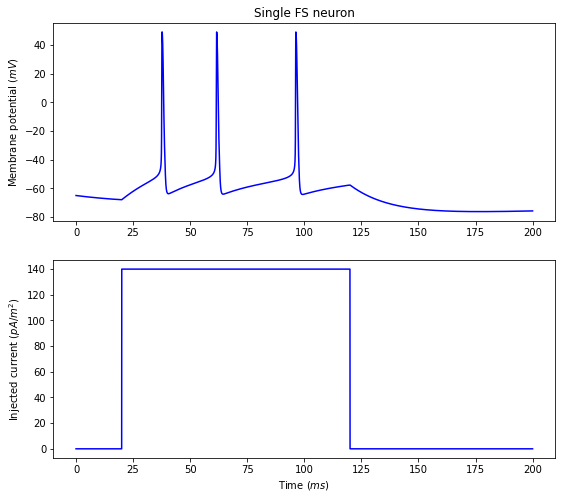

In [15]:
# simulation must be run in the new network, otherwise MagicError
network_single_FS_neuron.run(begin_time)
single_FS_neuron.I_app = injected_current
network_single_FS_neuron.run(stim_time)
single_FS_neuron.I_app = 0*amp/(meter**2)
network_single_FS_neuron.run(end_time)

# Plot
figure(figsize=(9, 8))

subplot(2,1,1)
title('Single FS neuron')
plot(statemonFS.t/ms, statemonFS.v[0]/mV, '-b') 
ylabel('Membrane potential ($mV$)')

subplot(2,1,2)
plot(statemonFS.t/ms, statemonFS.I_app[0]/(1e-12*amp*meter**-2), '-b')
ylabel('Injected current ($pA/m^2$)')
xlabel('Time ($ms$)')

show()

# fI-plot

To analyse the RS and FS neuron, we can compare the firing rate againt stimulus current (fI-plot) with experimental data for this. We use instantaneous firing rate here, so the inverse of the mean interval between (the first few) consecutive spikes.

We now stimulate the neurons a few times to get the data. First, set up the neuron and test currents.

The starting current is 70 pA/m^2 in this example, because otherwise the simulation has to take a lot longer to reach at least 2 spikes for every trial (which is needed for a frequency calculation).

In [16]:
test_currents = np.arange(80, 600, 10)*1e-12*amp/(meter**2)

# empty list to save found frequencies
freqs_RS = []

# Make the RS neuron that will be tested
test_neuron_RS = NeuronGroup(1, eqs_HH_RS_no_synapes,
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

# Set initial values
initial_values = {'v':-65*mV}
test_neuron_RS.set_states(initial_values)

# Monitors
statemon_test_RS = StateMonitor(test_neuron_RS, ('v', 'I_app'), record=True)
spikemon_test_RS = SpikeMonitor(test_neuron_RS, variables='v')

# Create a new network to run the test neuron in
network_test_neuron_RS = Network(test_neuron_RS, statemon_test_RS, spikemon_test_RS)

# save the initial state of the network, so for every test current
# the network will have the same initial values
network_test_neuron_RS.store()

Now we try all the test currents in a loop:

(running takes long)

In [17]:
for cur in test_currents:  
    # restore the network so it is in its initial condtions
    network_test_neuron_RS.restore()
     
    # Set the testcurrent
    test_neuron_RS.I_app = cur 
    
    # Run the simulation
    network_test_neuron_RS.run(500*ms)
    
    # Calculate the frequencies
    spike_times = spikemon_test_RS.t
    ISI = np.mean(np.diff(spike_times)) # inter spike interval
    firing_rate = 1/ISI #frequency
    freqs_RS.append(firing_rate)

and plot it

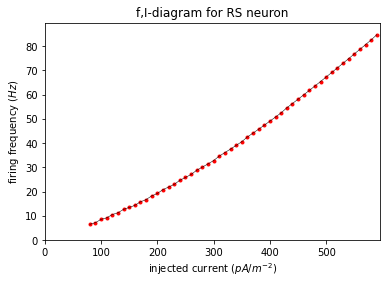

In [18]:
# Plot
plot(test_currents/(1e-12*amp/(meter**2)), freqs_RS/Hz,c='k', linewidth=0.5)
scatter(test_currents/(1e-12*amp/(meter**2)), freqs_RS/Hz,c='r', marker='.')
xlabel('injected current ($pA/m^{-2}$)')
ylabel('firing frequency ($Hz$)')
title('f,I-diagram for RS neuron')
xlim(0, test_currents[-1]/(1e-12*amp/(meter**2))+5)
ylim(0, freqs_RS[-1]/Hz+5)
show()

Now we also calculate it for the FS neuron and plot the results together with the RS fI-plot

In [19]:
# empty list to save found frequencies
freqs_FS = []

# Make the FS neuron that will be tested
test_neuron_FS = NeuronGroup(1, eqs_HH_FS_no_synapes,
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

# Set initial values
initial_values = {'v':-65*mV}
test_neuron_FS.set_states(initial_values)

# Monitors
statemon_test_FS = StateMonitor(test_neuron_FS, ('v', 'I_app'), record=True)
spikemon_test_FS = SpikeMonitor(test_neuron_FS, variables='v')

# Create a new network to run the test neuron in
network_test_neuron_FS = Network(test_neuron_FS, statemon_test_FS, spikemon_test_FS)

# save the initial state of the network, so for every test current
# the network will have the same initial values
network_test_neuron_FS.store()

In [20]:
for cur in test_currents:  
    # restore the network so it is in its initial condtions
    network_test_neuron_FS.restore()
     
    # Set the testcurrent
    test_neuron_FS.I_app = cur 
    
    # Run the simulation
    network_test_neuron_FS.run(500*ms)
    
    # Calculate the frequencies
    spike_times = spikemon_test_FS.t
    ISI = np.mean(np.diff(spike_times)) # inter spike interval
    firing_rate = 1/ISI #frequency
    freqs_FS.append(firing_rate)

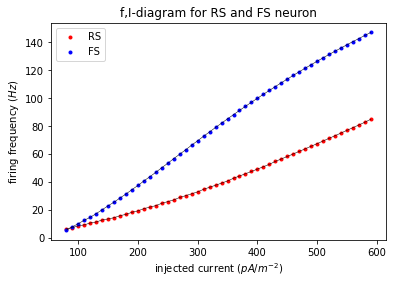

In [21]:
# Plot the fI diagram for both RS and FS neurons

plot(test_currents/(1e-12*amp/(meter**2)), freqs_RS/Hz,c='k', linewidth=0.5)
scatter(test_currents/(1e-12*amp/(meter**2)), freqs_RS/Hz,c='r', marker='.', label='RS')

plot(test_currents/(1e-12*amp/(meter**2)), freqs_FS/Hz,c='k', linewidth=0.5)
scatter(test_currents/(1e-12*amp/(meter**2)), freqs_FS/Hz,c='b', marker='.', label='FS')

xlabel('injected current ($pA/m^{-2}$)')
ylabel('firing frequency ($Hz$)')
title('f,I-diagram for RS and FS neuron')

legend()
show()

# Building the layers and including synapses
## Single layer synapse

Now we make layer 4 and include connections between the neurons. The size of the neuronpools are based on Meyer et al., 2010 (DOI: 10.1093/cercor/bhq067) and will be downscaled with a certain facor `f_downscale`. We take 85% percent of this to be RS, so excitatory and 15% to be FS, so inhibitory neurons.

We use a certain seed, so the 'random' values (for connecting synapses) will be the same each run, which makes it easier for now to see the effect of changing parts of the code. Seed(4) is chosen because the first 3 seeds happen to give synapses with 0 connections if the downscaling factor is 100, which Brian can't run.

In [6]:
seed(4) # otherwise error if downscalefactor is 100
f_downscale = 20 #factor for downscaling (make 20 in the end)

In [7]:
# Set the layers
number_of_neurons_L4 = 4447

# Calculate number of neurons of both types with downscaling
eNum_perc = 0.85
iNum_perc = 0.15

N_E_L4 = int(floor(number_of_neurons_L4*eNum_perc/f_downscale))
N_I_L4 = int(floor(number_of_neurons_L4*iNum_perc/f_downscale))
N_L4 = N_E_L4 + N_I_L4 #total number of neurons that are simulated

Now we set the parameters for the synapses. Synapse equations (later on) and parameters are taken from Dynasim and scaled for the correct uEPSP and uIPSP.

In [8]:
# Weights and scaling regulate the influence of received synaptic currents,
# scaled now to uEPSP and uIPSP are ~2mV and -4.5mV (source)
AMPA_scale = 0.17
GABAa_scale = 0.5
weight_s = 1 
weight_z = 1

# AMPA parameters for RS / E neurons
# Values are taken from Dynasim model for AMPA and GABAa ergic synapses
Esyn_AMPA = 0 * mV  
gsyn_AMPA = 0.1 * msiemens/(meter**2)*1e-4*AMPA_scale
slope_AMPA = 10/1000 * volt
taud_AMPA = 2 * ms
taur_AMPA = 0.1* ms

# GABA parameters for FS/ I neurons
# Values are taken from Dynasim
EGABA = -80 * mV
gsyn_GABA = 0.25 * msiemens/(meter**2)*1e-4*GABAa_scale
tauD_GABA = 10 * ms
tauR_GABA = 0.2 * ms
slope_GABA = 10/1000 * volt

To include the synapses, new neuron equations are needed. The synapses are based on the Dynasim model for continous synapses, where a membrane potential dependend parameter (`s` for excitatory or `z` for inhibitory) is traced on the pre-synaptic neuron, that get added to a differentiable parameter the post-synaptic neuron (eg. `s_in_EE`). By adding `s` or `z` to one specific parameter, we can nicely trace the synaptic input for each neuron. This is traced with `Isyn_E` and `Isyn_I`, for excitatory and inhibitory input, respectively. All s-values represent effect from AMPA-ergic synapses and all z-values GABA-ergic synapses.

In [44]:
eqs_HH_E_one_layer = '''
I = IK + INa + IM + I_leak+ I_app + Isyn_E + Isyn_I  : amp * meter**-2
dv/dt = I/Cm  : volt 

Isyn_E = + s_in_EE * gsyn_AMPA*-(v-Esyn_AMPA) + s_in_EI * gsyn_AMPA*-(v-Esyn_AMPA): amp * meter**-2
Isyn_I = -1*( + z_in_II * gsyn_GABA*(v-EGABA) + z_in_IE * gsyn_GABA*(v-EGABA) ) : amp * meter**-2

I_app : amp * meter**-2

s_in_EE : 1
s_in_EI : 1
z_in_IE : 1
z_in_II : 1

dn/dt = alpha_n * (1-n) - beta_n * n: 1
dm/dt = alpha_m * (1-m) - beta_m * m : 1
dh/dt = alpha_h * (1-h) - beta_h * h: 1
dp/dt = (p_inf - p)/tau_p : 1

alpha_n = -0.0320/mV*(v-E_V_T-15.0*mV) / (exp( -(v-E_V_T - 15.0*mV)/(5.0*mV)) - 1) * 1/msecond : Hz     
beta_n = 0.50 * exp( -(v-E_V_T - 10.0*mV)/(40.0*mV))*1/msecond : Hz
alpha_m =  -0.32/mV*(v-E_V_T-13.*mV) / (exp(-(v-E_V_T-13.*mV)/(4.*mV))-1)*1/msecond:Hz
beta_m = ( 0.28/mV * ((v-E_V_T-40.*mV))) / (exp((v-E_V_T-40.*mV)/(5.*mV))-1 ) *1/msecond : Hz
alpha_h = 0.128 * exp(-(v-E_V_T-17.*mV)/(18.*mV)) *1/msecond : Hz
beta_h = 4./(1.+exp(-(v-E_V_T-40.*mV)/(5.*mV))) *1/msecond : Hz
p_inf = 1 / (1.+exp(-(v+35.*mV)/(10.*mV))) : 1
tau_p = E_tau_max_M /( (3.3*exp((v+35.*mV)/(20.*mV)) + exp(-(v+35.*mV)/(20.*mV)))) : second 

IK    = -E_gK * n**4 *(v-EK) : amp * meter**-2
INa   = -E_gNa*m**3*h*(v-ENa)   : amp * meter**-2
IM    = -E_gM *p *(v-E_M)  : amp * meter**-2

I_leak = -E_gleak*(v-E_Eleak): amp * meter**-2

ds/dt = -s/taud_AMPA + 1/2 * (1 + tanh(v/slope_AMPA)) * (1-s)/taur_AMPA : 1 
'''

In [45]:
eqs_HH_I_one_layer = '''
I = IK + INa + IM + I_leak+ I_app + Isyn_E + Isyn_I  : amp * meter**-2
dv/dt = I/Cm  : volt

Isyn_E = + s_in_EE * gsyn_AMPA*-(v-Esyn_AMPA) + s_in_EI * gsyn_AMPA*-(v-Esyn_AMPA): amp * meter**-2
Isyn_I = -1*( + z_in_II * gsyn_GABA*(v-EGABA) + z_in_IE * gsyn_GABA*(v-EGABA) ) : amp * meter**-2

I_app : amp * meter**-2

s_in_EE : 1
s_in_EI : 1
z_in_IE : 1
z_in_II : 1

dn/dt = alpha_n * (1-n) - beta_n * n: 1
dm/dt = alpha_m * (1-m) - beta_m * m : 1
dh/dt = alpha_h * (1-h) - beta_h * h: 1
dp/dt = (p_inf - p)/tau_p : 1

alpha_n = -0.0320/mV*(v-I_V_T-15.0*mV) / (exp( -(v-I_V_T - 15.0*mV)/(5.0*mV)) - 1) * 1/msecond : Hz     
beta_n = 0.50 * exp( -(v-I_V_T - 10.0*mV)/(40.0*mV))*1/msecond : Hz
alpha_m =  -0.32/mV*(v-I_V_T-13.*mV) / (exp(-(v-I_V_T-13.*mV)/(4.*mV))-1)*1/msecond:Hz
beta_m = ( 0.28/mV * ((v-I_V_T-40.*mV))) / (exp((v-I_V_T-40.*mV)/(5.*mV))-1 ) *1/msecond : Hz
alpha_h = 0.128 * exp(-(v-I_V_T-17.*mV)/(18.*mV)) *1/msecond : Hz
beta_h = 4./(1.+exp(-(v-I_V_T-40.*mV)/(5.*mV))) *1/msecond : Hz
p_inf = 1 / (1.+exp(-(v+35.*mV)/(10.*mV))) : 1
tau_p = I_tau_max_M /( (3.3*exp((v+35.*mV)/(20.*mV)) + exp(-(v+35.*mV)/(20.*mV)))) : second

IK    = -I_gK * n**4 *(v-EK) : amp * meter**-2
INa   = -I_gNa*m**3*h*(v-ENa)   : amp * meter**-2
IM    = -I_gM *p *(v-E_M)  : amp * meter**-2

I_leak = -I_gleak*(v-I_Eleak): amp * meter**-2

dz/dt = -z/tauD_GABA + 1/2 * (1 + tanh(v/slope_GABA)) * (1-z)/tauR_GABA : 1 
'''

Now we make the pools of neurons again.

In [27]:
E_pool_L4_only = NeuronGroup(N_E_L4, eqs_HH_E_one_layer,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

I_pool_L4_only = NeuronGroup(N_I_L4, eqs_HH_I_one_layer,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

# Set initial values
IC = {'v':-65*mV}
E_pool_L4_only.set_states(IC)
I_pool_L4_only.set_states(IC)

To create and connect the synapses, first a synapse class has to be created (without connections yet), then with possibilities of connection taken from the [https://bbp.epfl.ch/nmc-portal/microcircuit.html](Blue Brain Project), we create a list with ones and zeros, ones representing a connection, and connect the synapses with this.

In [28]:
# Synapses L4
synEE_L4_only = Synapses(E_pool_L4_only, E_pool_L4_only, 's_in_EE_post = weight_s*s_pre:1 (summed)') 
synEI_L4_only = Synapses(E_pool_L4_only, I_pool_L4_only, 's_in_EI_post = weight_s*s_pre:1 (summed)') 
synIE_L4_only = Synapses(I_pool_L4_only, E_pool_L4_only, 'z_in_IE_post = weight_z*z_pre:1 (summed)') 
synII_L4_only = Synapses(I_pool_L4_only, I_pool_L4_only, 'z_in_II_post = weight_z*z_pre:1 (summed)')

`pEE_L4` represents the possibility of an RS neuron connecting with another RS neuron (E-E), `pEI_L4` represents RS connecting to FS (E-I) etc.

In [9]:
# Connect the pools with experimentally found probabilities
pEE_L4, pII_L4, pEI_L4, pIE_L4 = 7.6/100, 6.2/100, 4.2/100, 6.3/100 

I made a randomization function (`prob_matrix()`), to not only connect the first few indexed neurons of a layer. This creates the possibility of adjusting some specific parameters within a neuron pool while still having the synapses randomly distributed. For example, in the thalamic layer, some neurons are shifted more than others. These neurons that cause the noise are the last indexed neurons. By including the randomization, these neurons can be included too. Furthermore, with randomization, the first indexed neurons are not always targeted for postsynaptic connections. This creates a good distribution between connecting and connected neurons within a pool of neurons. Lastly, the function excludes self-connections.

In [10]:
# Makes list with random 'connections' based on the possibility, so that
# the order of created neurons doesn't matter (later on not every neuron
# in a group will have the same parameters)
def prob_matrix(N, M, prob_of_con): 
    prob_list = []
    for i in range(N):
        sub_list = []
        for j in range(M):
            index = np.random.choice([0, 1], p=[1-prob_of_con, prob_of_con])
            if M==N and i==j: #now a neuron cannot connect to itself
                index = 0
            sub_list.append(index)
        prob_list.append(sub_list)
    return prob_list

and connect:

In [31]:
pos_listEE_L4 = prob_matrix(N_E_L4, N_E_L4, pEE_L4)
for pre_n in range(N_E_L4): #loop over pre_syn neuron
    for post_n in range(N_E_L4): # now loop post syn neuron
        if pos_listEE_L4[pre_n][post_n] == 1 and pre_n != post_n:
            synEE_L4_only.connect(i=pre_n, j=post_n)
            
pos_listEI_L4 = prob_matrix(N_E_L4, N_I_L4, pEI_L4)
for pre_n in range(N_E_L4): 
    for post_n in range(N_I_L4):
        if pos_listEI_L4[pre_n][post_n] == 1:
            synEI_L4_only.connect(i=pre_n, j=post_n)
            
pos_listIE_L4 = prob_matrix(N_I_L4, N_E_L4, pIE_L4)
for pre_n in range(N_I_L4): 
    for post_n in range(N_E_L4):
        if pos_listIE_L4[pre_n][post_n] == 1:
            synIE_L4_only.connect(i=pre_n, j=post_n)
            
pos_listII_L4 = prob_matrix(N_I_L4, N_I_L4, pII_L4)
for pre_n in range(N_I_L4): 
    for post_n in range(N_I_L4):
        if pos_listII_L4[pre_n][post_n] == 1 and pre_n != post_n:
            synII_L4_only.connect(i=pre_n, j=post_n)

We can run this system again and monitor it.

In [32]:
# Layer 4
M_E_L4_only = StateMonitor(E_pool_L4_only, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
M_I_L4_only = StateMonitor(I_pool_L4_only, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
spikemon_E_L4_only = SpikeMonitor(E_pool_L4_only, variables='v')
spikemon_I_L4_only = SpikeMonitor(I_pool_L4_only, variables='v')

In [33]:
# Create network to allow it to run without restarting kernel
network_only_L4 = Network(E_pool_L4_only, I_pool_L4_only, 
                          M_E_L4_only, M_I_L4_only, 
                          spikemon_E_L4_only, spikemon_I_L4_only,
                         synEE_L4_only, synEI_L4_only, synIE_L4_only, synII_L4_only)

Run it with 20% of RS neurons and 30% of FS neurons stimulated.

In [34]:
injected_current = 140e-12*amp/(meter**2)

perc_E_stim = int(round(N_E_L4*0.2)) # only a % of the neurons get the stimilus
perc_I_stim = int(round(N_I_L4*0.3))

E_pool_L4_only.I_app[:perc_E_stim] = injected_current
I_pool_L4_only.I_app[:perc_I_stim] = injected_current
network_only_L4.run(simulation_duration)

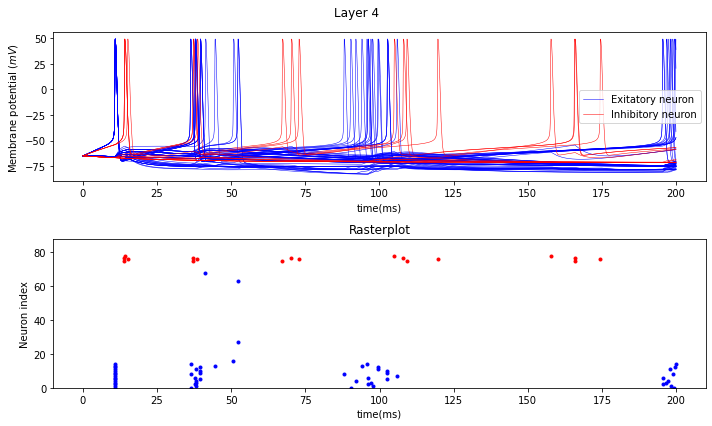

In [35]:
figure(figsize=(10, 6))
suptitle('Layer 4')

# plot membrane potential
subplot(211)
plot(M_E_L4_only.t/ms, M_E_L4_only.v[0]/mV, label='Exitatory neuron',  c='b', linewidth = 0.5) #plot the first ones seperately for the legend
plot(M_I_L4_only.t/ms, M_I_L4_only.v[0]/mV, label='Inhibitory neuron', c='r', linewidth = 0.5)
for neuron in range(1, N_E_L4):
    plot(M_E_L4_only.t/ms, M_E_L4_only.v[neuron]/mV,  c='b', linewidth = 0.5)
for neuron in range(1, N_I_L4):
    plot(M_I_L4_only.t/ms, M_I_L4_only.v[neuron]/mV, c='r', linewidth = 0.5)

ylabel('Membrane potential ($mV$)')
xlabel('time(ms)')
legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
legend()

# plot rasterplot
subplot(212)
time = np.arange(0, (simulation_duration)/ms)
plt.scatter(time[-1], 5, c='w')
plt.scatter(time[0], 5, c='w')
ylim(0, N_L4)

dataE = spikemon_E_L4_only.spike_trains()
dataI = spikemon_I_L4_only.spike_trains()
neurons = np.arange(0, N_E_L4)

for neuron in range(N_E_L4):
    for spike in range(len(dataE[neuron])):
        plt.scatter(dataE[neuron][spike]/ms, neuron, c='b', marker='.')
for neuron in range(N_I_L4):
    for spike in range(len(dataI[neuron])):
        plt.scatter(dataI[neuron][spike]/ms, neuron+N_E_L4, c='r', marker='.')

title('Rasterplot')  
ylabel('Neuron index')
xlabel('time(ms)')

tight_layout()
show()

# Synapses for all layers

To add layer 3 and the thalamic layer, the neuron equations have te be changed again to include the synapses between thm-L4 and L4-thm. First a network will be created where the thalamic layer receives a current pulse input, then poisson-like input and lastly we will stimulate it with regulated EPSCs.

The size of L3 is also taken from Meyer et al., 2010, the size of the thalamic layer is chosen to be 70.

In [11]:
number_of_neurons_L3 = 3735
num_thm = 70

N_E_L3 = int(floor(number_of_neurons_L3*eNum_perc/f_downscale))
N_I_L3 = int(floor(number_of_neurons_L3*iNum_perc/f_downscale))

N_L3 = N_E_L3 + N_I_L3

In [12]:
# Unitairy weights set on 1 which were used to calibrate
# the uPSPs
weight_s = 1 
weight_z = 1
weight_thm = 1

# Weights for the kinds of synapses
# thalamus to L4
w_thm_L4E = 7
w_thm_L4I = 9

# L4 to L4
w_L4E_L4E = 1.65
w_L4E_L4I = 7.9
w_L4I_L4E = 16
w_L4I_L4I = 14

# L4 to L3
w_L4E_L3E = 2.4
w_L4E_L3I = 5.7
w_L4I_L3E = 14

# L3 to L3
w_L3E_L3E = 2.8
w_L3E_L3I = 8.1
w_L3I_L3E = 17
w_L3I_L3I = 15

There is no `z_in_II_inter` because the possibility of L4 I -> L3 I connections is 0.

In [13]:
eqs_HH_E = '''
I = IK + INa + IM + I_leak+ I_app + Isyn_E + Isyn_I  : amp * meter**-2
dv/dt = I/Cm  : volt 

Isyn_E = + s_in_EE * gsyn_AMPA*-(v-Esyn_AMPA) + s_in_EI * gsyn_AMPA*-(v-Esyn_AMPA)
            + s_in_EE_inter * gsyn_AMPA * -(v-Esyn_AMPA) 
            + s_in_EI_inter * gsyn_AMPA * -(v-Esyn_AMPA)
            + s_in_VPM * gsyn_AMPA * -(v-Esyn_AMPA) : amp * meter**-2
Isyn_I = -1*( + z_in_II * gsyn_GABA*(v-EGABA) + z_in_IE * gsyn_GABA*(v-EGABA)  
            + z_in_IE_inter * gsyn_GABA*(v-EGABA) ) : amp * meter**-2

I_app : amp * meter**-2

s_in_EE : 1
s_in_EI : 1
z_in_IE : 1
z_in_II : 1
s_in_EI_inter : 1
s_in_EE_inter : 1
z_in_IE_inter : 1
s_in_VPM : 1

dn/dt = alpha_n * (1-n) - beta_n * n: 1
dm/dt = alpha_m * (1-m) - beta_m * m : 1
dh/dt = alpha_h * (1-h) - beta_h * h: 1
dp/dt = (p_inf - p)/tau_p : 1

alpha_n = -0.0320/mV*(v-I_V_T-15.0*mV) / (exp( -(v-I_V_T - 15.0*mV)/(5.0*mV)) - 1) * 1/msecond : Hz     
beta_n = 0.50 * exp( -(v-I_V_T - 10.0*mV)/(40.0*mV))*1/msecond : Hz
alpha_m =  -0.32/mV*(v-I_V_T-13.*mV) / (exp(-(v-I_V_T-13.*mV)/(4.*mV))-1)*1/msecond:Hz
beta_m = ( 0.28/mV * ((v-I_V_T-40.*mV))) / (exp((v-I_V_T-40.*mV)/(5.*mV))-1 ) *1/msecond : Hz
alpha_h = 0.128 * exp(-(v-I_V_T-17.*mV)/(18.*mV)) *1/msecond : Hz
beta_h = 4./(1.+exp(-(v-I_V_T-40.*mV)/(5.*mV))) *1/msecond : Hz
p_inf = 1 / (1.+exp(-(v+35.*mV)/(10.*mV))) : 1
tau_p = I_tau_max_M /( (3.3*exp((v+35.*mV)/(20.*mV)) + exp(-(v+35.*mV)/(20.*mV)))) : second

IK    = -E_gK * n**4 *(v-EK) : amp * meter**-2
INa   = -E_gNa*m**3*h*(v-ENa)   : amp * meter**-2
IM    = -E_gM *p *(v-E_M)  : amp * meter**-2

I_leak = -E_gleak*(v-E_Eleak): amp * meter**-2

ds/dt = -s/taud_AMPA + 1/2 * (1 + tanh(v/slope_AMPA)) * (1-s)/taur_AMPA : 1
'''

eqs_HH_I = '''
I = IK + INa + IM + I_leak+ I_app + Isyn_E + Isyn_I  : amp * meter**-2
dv/dt = I/Cm  : volt

Isyn_E = + s_in_EE * gsyn_AMPA*-(v-Esyn_AMPA) + s_in_EI * gsyn_AMPA*-(v-Esyn_AMPA)
            + s_in_EE_inter * gsyn_AMPA * -(v-Esyn_AMPA) 
            + s_in_EI_inter * gsyn_AMPA * -(v-Esyn_AMPA)
            + s_in_VPM * gsyn_AMPA * -(v-Esyn_AMPA) : amp * meter**-2
Isyn_I = -1*( + z_in_II * gsyn_GABA*(v-EGABA) + z_in_IE * gsyn_GABA*(v-EGABA)  
            + z_in_IE_inter * gsyn_GABA*(v-EGABA) ): amp * meter**-2

I_app : amp * meter**-2

s_in_EE : 1
s_in_EI : 1
z_in_IE : 1
z_in_II : 1
s_in_EI_inter : 1
s_in_EE_inter : 1
z_in_IE_inter : 1
s_in_VPM : 1

dn/dt = alpha_n * (1-n) - beta_n * n: 1
dm/dt = alpha_m * (1-m) - beta_m * m : 1
dh/dt = alpha_h * (1-h) - beta_h * h: 1
dp/dt = (p_inf - p)/tau_p : 1

alpha_n = -0.0320/mV*(v-I_V_T-15.0*mV) / (exp( -(v-I_V_T - 15.0*mV)/(5.0*mV)) - 1) * 1/msecond : Hz     
beta_n = 0.50 * exp( -(v-I_V_T - 10.0*mV)/(40.0*mV))*1/msecond : Hz
alpha_m =  -0.32/mV*(v-I_V_T-13.*mV) / (exp(-(v-I_V_T-13.*mV)/(4.*mV))-1)*1/msecond:Hz
beta_m = ( 0.28/mV * ((v-I_V_T-40.*mV))) / (exp((v-I_V_T-40.*mV)/(5.*mV))-1 ) *1/msecond : Hz
alpha_h = 0.128 * exp(-(v-I_V_T-17.*mV)/(18.*mV)) *1/msecond : Hz
beta_h = 4./(1.+exp(-(v-I_V_T-40.*mV)/(5.*mV))) *1/msecond : Hz
p_inf = 1 / (1.+exp(-(v+35.*mV)/(10.*mV))) : 1
tau_p = I_tau_max_M /( (3.3*exp((v+35.*mV)/(20.*mV)) + exp(-(v+35.*mV)/(20.*mV)))) : second

IK    = -I_gK * n**4 *(v-EK) : amp * meter**-2
INa   = -I_gNa*m**3*h*(v-ENa)   : amp * meter**-2
IM    = -I_gM *p *(v-E_M)  : amp * meter**-2

I_leak = -I_gleak*(v-I_Eleak): amp * meter**-2
 
dz/dt = -z/tauD_GABA + 1/2 * (1 + tanh(v/slope_GABA)) * (1-z)/tauR_GABA : 1  
'''

The neuron equations for thalamus are simplified from `eqs_HH_E`, because only their output is important (they won't get synaptic input). 

In [14]:
eqs_HH_thm_pulse_input = '''
dv/dt = (IK + INa + IM + I_leak+ I_app)/Cm  : volt

I = IK + INa + IM + I_leak+ I_app : amp * meter**-2

I_app : amp * meter**-2

dn/dt = alpha_n * (1-n) - beta_n * n: 1
dm/dt = alpha_m * (1-m) - beta_m * m : 1
dh/dt = alpha_h * (1-h) - beta_h * h: 1
dp/dt = (p_inf - p)/tau_p : 1

alpha_n = -0.0320/mV*(v-I_V_T-15.0*mV) / (exp( -(v-I_V_T - 15.0*mV)/(5.0*mV)) - 1) * 1/msecond : Hz     
beta_n = 0.50 * exp( -(v-I_V_T - 10.0*mV)/(40.0*mV))*1/msecond : Hz
alpha_m =  -0.32/mV*(v-I_V_T-13.*mV) / (exp(-(v-I_V_T-13.*mV)/(4.*mV))-1)*1/msecond:Hz
beta_m = ( 0.28/mV * ((v-I_V_T-40.*mV))) / (exp((v-I_V_T-40.*mV)/(5.*mV))-1 ) *1/msecond : Hz
alpha_h = 0.128 * exp(-(v-I_V_T-17.*mV)/(18.*mV)) *1/msecond : Hz
beta_h = 4./(1.+exp(-(v-I_V_T-40.*mV)/(5.*mV))) *1/msecond : Hz
p_inf = 1 / (1.+exp(-(v+35.*mV)/(10.*mV))) : 1
tau_p = I_tau_max_M /( (3.3*exp((v+35.*mV)/(20.*mV)) + exp(-(v+35.*mV)/(20.*mV)))) : second

IK    = -E_gK * n**4 *(v-EK) : amp * meter**-2
INa   = -E_gNa*m**3*h*(v-ENa)   : amp * meter**-2
IM    = -E_gM *p *(v-E_M)  : amp * meter**-2

I_leak = -E_gleak*(v-E_Eleak): amp * meter**-2

ds/dt = -s/taud_AMPA + 1/2 * (1 + tanh(v/slope_AMPA)) * (1-s)/taur_AMPA : 1 
'''

Now we create the neuron pools again. This has to be done again for L4 also because the neuron equations are different now.

In [40]:
# Make the pools of neurons
# Because E and I have different equations, they must be different groups
E_pool_L4 = NeuronGroup(N_E_L4, eqs_HH_E,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

I_pool_L4 = NeuronGroup(N_I_L4, eqs_HH_I,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

E_pool_L3 = NeuronGroup(N_E_L3, eqs_HH_E,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

I_pool_L3 = NeuronGroup(N_I_L3, eqs_HH_I,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

thm_group_pulse_input = NeuronGroup(num_thm, eqs_HH_thm_pulse_input,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler')

# Set initial values
IC = {'v':-65*mV}
E_pool_L4.set_states(IC)
I_pool_L4.set_states(IC)
E_pool_L3.set_states(IC)
I_pool_L3.set_states(IC)
thm_group_pulse_input.set_states(IC)

New types of synapses will be created now: `synEE_inter` etc. are the synapses from layer 4 to layer 3 neurons, `syn_thm_E` are the synapses from the thalamic layer to the E pool in L4.

In [41]:
# Create the synapses
# Synapses L4
synEE_L4 = Synapses(E_pool_L4, E_pool_L4, 's_in_EE_post = w_L4E_L4E*weight_s*s_pre:1 (summed)') 
synEI_L4 = Synapses(E_pool_L4, I_pool_L4, 's_in_EI_post = w_L4E_L4I*weight_s*s_pre:1 (summed)') 
synIE_L4 = Synapses(I_pool_L4, E_pool_L4, 'z_in_IE_post = w_L4I_L4E*weight_z*z_pre:1 (summed)') 
synII_L4 = Synapses(I_pool_L4, I_pool_L4, 'z_in_II_post = w_L4I_L4I*weight_z*z_pre:1 (summed)')

# Synapses L3
synEE_L3 = Synapses(E_pool_L3, E_pool_L3, 's_in_EE_post = w_L3E_L3E*weight_s*s_pre:1 (summed)') 
synEI_L3 = Synapses(E_pool_L3, I_pool_L3, 's_in_EI_post = w_L3E_L3I*weight_s*s_pre:1 (summed)') 
synIE_L3 = Synapses(I_pool_L3, E_pool_L3, 'z_in_IE_post = w_L3I_L3E*weight_z*z_pre:1 (summed)') 
synII_L3 = Synapses(I_pool_L3, I_pool_L3, 'z_in_II_post = w_L3I_L3I*weight_z*z_pre:1 (summed)') 

#synapses for interlayer connections between L3 and L4
synEE_inter = Synapses(E_pool_L4, E_pool_L3, 's_in_EE_inter_post = w_L4E_L3E*weight_s*s_pre:1 (summed)') 
synIE_inter = Synapses(I_pool_L4, E_pool_L3, 'z_in_IE_inter_post = w_L4I_L3E*weight_z*z_pre:1 (summed)') 
synEI_inter = Synapses(E_pool_L4, I_pool_L3, 's_in_EI_inter_post = w_L4E_L3I*weight_s*s_pre:1 (summed)') 

# Synapses for VPM connections (thm -> L4)
syn_thm_E = Synapses(thm_group, E_pool_L4, 's_in_VPM_post = w_thm_L4E*weight_thm*s_pre:1 (summed)')
syn_thm_I = Synapses(thm_group, I_pool_L4, 's_in_VPM_post = w_thm_L4I*weight_thm*s_pre:1 (summed)')


Connect them now (the cell with `def prob_matrix(N, M, prob_of_con)` must be run for this).

The values of possibility are also taken from the Blue Brain Project data.

In [15]:
# possibilities of L3 connections
pEE_L3, pII_L3, pEI_L3, pIE_L3 = 5.6/100, 5.1/100, 5.1/100, 5.9/100

#possibilities of interlayer connections
pEE_inter = 0.58/100 
pEI_inter = 0.33/100
pIE_inter = 1.7/100

#connections from the thalamus
pVPM_E = 4.3/100 
pVPM_I = 5/100

In [43]:
pos_listEE_L4 = prob_matrix(N_E_L4, N_E_L4, pEE_L4)
for pre_n in range(N_E_L4): #loop over pre_syn neuron
    for post_n in range(N_E_L4): # now loop post syn neuron
        if pos_listEE_L4[pre_n][post_n] == 1 and pre_n != post_n:
            synEE_L4.connect(i=pre_n, j=post_n)
            
pos_listEI_L4 = prob_matrix(N_E_L4, N_I_L4, pEI_L4)
for pre_n in range(N_E_L4): 
    for post_n in range(N_I_L4):
        if pos_listEI_L4[pre_n][post_n] == 1:
            synEI_L4.connect(i=pre_n, j=post_n)
            
pos_listIE_L4 = prob_matrix(N_I_L4, N_E_L4, pIE_L4)
for pre_n in range(N_I_L4): 
    for post_n in range(N_E_L4):
        if pos_listIE_L4[pre_n][post_n] == 1:
            synIE_L4.connect(i=pre_n, j=post_n)
            
pos_listII_L4 = prob_matrix(N_I_L4, N_I_L4, pII_L4)
for pre_n in range(N_I_L4): 
    for post_n in range(N_I_L4):
        if pos_listII_L4[pre_n][post_n] == 1 and pre_n != post_n:
            synII_L4.connect(i=pre_n, j=post_n)
            
# L3 cons            
pos_listEE_L3 = prob_matrix(N_E_L3, N_E_L3, pEE_L3)
for pre_n in range(N_E_L3): #loop over pre_syn neuron
    for post_n in range(N_E_L3): # now loop post syn neuron
        if pos_listEE_L3[pre_n][post_n] == 1 and pre_n != post_n:
            synEE_L3.connect(i=pre_n, j=post_n)
            
pos_listEI_L3 = prob_matrix(N_E_L3, N_I_L3, pEI_L3)
for pre_n in range(N_E_L3): 
    for post_n in range(N_I_L3):
        if pos_listEI_L3[pre_n][post_n] == 1:
            synEI_L3.connect(i=pre_n, j=post_n)
            
pos_listIE_L3 = prob_matrix(N_I_L3, N_E_L3, pIE_L3)
for pre_n in range(N_I_L3): 
    for post_n in range(N_E_L3):
        if pos_listIE_L3[pre_n][post_n] == 1:
            synIE_L3.connect(i=pre_n, j=post_n)
            
pos_listII_L3 = prob_matrix(N_I_L3, N_I_L3, pII_L3)
for pre_n in range(N_I_L3): 
    for post_n in range(N_I_L3):
        if pos_listII_L3[pre_n][post_n] == 1 and pre_n != post_n:
            synII_L3.connect(i=pre_n, j=post_n)  
            
# interlayer cons
pos_listEE_inter = prob_matrix(N_E_L4, N_E_L3, pEE_inter)
for pre_n in range(N_E_L4): 
    for post_n in range(N_E_L3):
        if pos_listEE_inter[pre_n][post_n] == 1 and pre_n != post_n:
            synEE_inter.connect(i=pre_n, j=post_n) 
            
pos_listEI_inter = prob_matrix(N_E_L4, N_I_L3, pEE_inter)
for pre_n in range(N_E_L4): 
    for post_n in range(N_I_L3):
        if pos_listEI_inter[pre_n][post_n] == 1 and pre_n != post_n:
            synEI_inter.connect(i=pre_n, j=post_n) 
            
pos_listIE_inter = prob_matrix(N_I_L4, N_E_L3, pEE_inter)
for pre_n in range(N_I_L4): 
    for post_n in range(N_E_L3):
        if pos_listIE_inter[pre_n][post_n] == 1 and pre_n != post_n:
            synIE_inter.connect(i=pre_n, j=post_n) 

# connect L4 to the thalamus input            
pos_list_thmE = prob_matrix(num_thm, N_E_L4, pVPM_E)
for pre_n in range(num_thm): 
    for post_n in range(N_E_L4): 
        if pos_list_thmE[pre_n][post_n] == 1 and pre_n != post_n:
            syn_thm_E.connect(i=pre_n, j=post_n)
            
pos_list_thmI = prob_matrix(num_thm, N_I_L4, pVPM_I)
for pre_n in range(num_thm): 
    for post_n in range(N_I_L4): 
        if pos_list_thmI[pre_n][post_n] == 1 and pre_n != post_n:
            syn_thm_I.connect(i=pre_n, j=post_n)

... and monitor it again:

In [44]:
# Layer 4
M_E_L4 = StateMonitor(E_pool_L4, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
M_I_L4 = StateMonitor(I_pool_L4, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
spikemon_E_L4 = SpikeMonitor(E_pool_L4, variables='v')
spikemon_I_L4 = SpikeMonitor(I_pool_L4, variables='v')

# Layer 3
M_E_L3 = StateMonitor(E_pool_L3, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
M_I_L3 = StateMonitor(I_pool_L3, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
spikemon_E_L3 = SpikeMonitor(E_pool_L3, variables='v')
spikemon_I_L3 = SpikeMonitor(I_pool_L3, variables='v')

# Thalamus monitor
statemon_thm = StateMonitor(thm_group_pulse_input, ('v', 'I', 'I_app'), record=True)
spikemon_thm = SpikeMonitor(thm_group_pulse_input, variables='v')

synmon_thm_E = StateMonitor(syn_thm_E, ('s_in_VPM_post', 's_pre'), record=True)
synmon_thm_I = StateMonitor(syn_thm_I, ('s_in_VPM_post', 's_pre'), record=True)

In [45]:
network_all_layers_pulse_input = Network(E_pool_L4, I_pool_L4, E_pool_L3, I_pool_L3, thm_group_pulse_input,
                                        M_E_L4, M_I_L4, spikemon_E_L4, spikemon_I_L4, M_E_L3, M_I_L3, spikemon_E_L3,
                                        spikemon_I_L3, spikemon_thm, statemon_thm, synmon_thm_E, synmon_thm_I,
                                        syn_thm_E, syn_thm_I, synEI_inter, synIE_inter, synEE_inter,
                                        synII_L3, synIE_L3, synEI_L3, synEE_L3, synII_L4, synIE_L4, 
                                        synEI_L4, synEE_L4)

network_all_layers_pulse_input.store()

We give all thalamus neurons a current pulse input and then run it.

In [46]:
network_all_layers_pulse_input.run(begin_time)
thm_group_pulse_input.I_app = injected_current*2
network_all_layers_pulse_input.run(stim_time)
thm_group_pulse_input.I_app = 0*amp/(meter**2)
network_all_layers_pulse_input.run(end_time)

Plot it

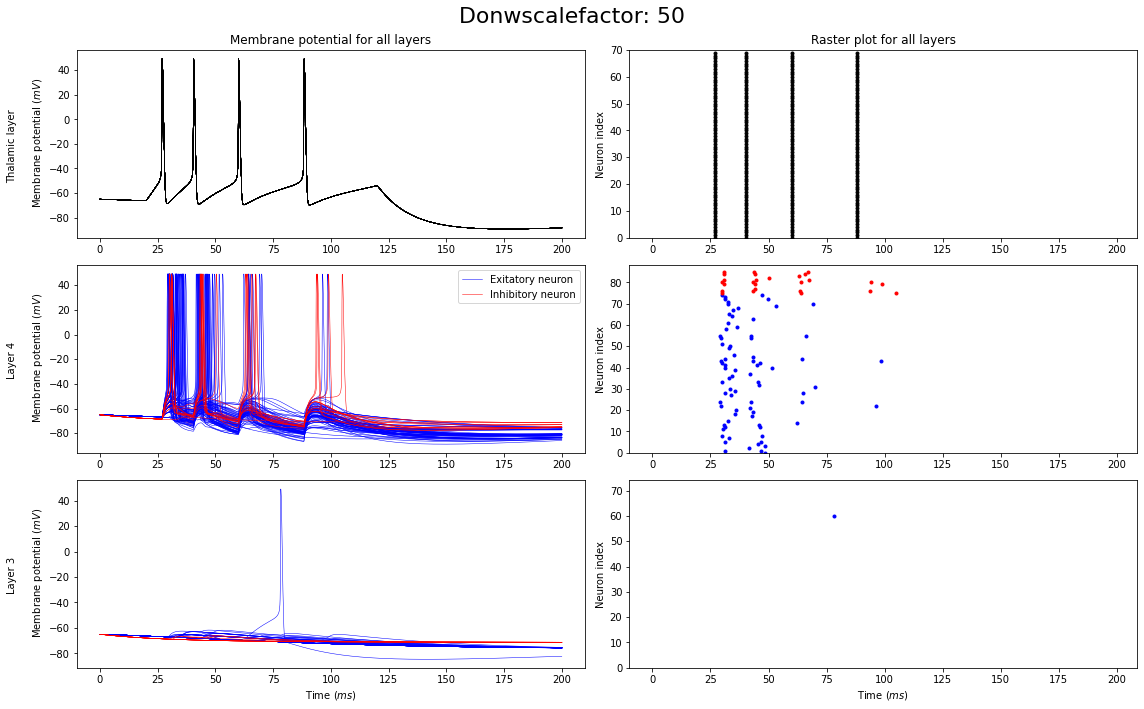

In [47]:
# Plotting the spikes
figure(figsize=(16, 10))

suptitle('Donwscalefactor: {}'.format(f_downscale), fontsize=22)

plt.subplot(321)
title('Membrane potential for all layers')
for neuron in range(0, num_thm):
    plot(statemon_thm.t/ms, statemon_thm.v[neuron]/mV,  c='k', linewidth = 0.5)
ylabel('Thalamic layer \n\n Membrane potential ($mV$)')

plt.subplot(322)
# mark the first and last time point so the axes align
time_p = np.arange(0, (simulation_duration)/ms)
plt.scatter(time_p[-1], 5, c='w')
plt.scatter(time_p[0], 5, c='w')
ylim(0, num_thm)
title('Raster plot for all layers')
data_thm = spikemon_thm.spike_trains()
neurons = np.arange(0, num_thm)
for neuron in range(num_thm):
    for spike in range(len(data_thm[neuron])):
        plt.scatter(data_thm[neuron][spike]/ms, neuron, c='k', marker='.')
ylabel('Neuron index')

plt.subplot(323)
plot(M_E_L4.t/ms, M_E_L4.v[0]/mV, label='Exitatory neuron',  c='b', linewidth = 0.5) #plot the first ones seperately for the legend
plot(M_I_L4.t/ms, M_I_L4.v[0]/mV, label='Inhibitory neuron', c='r', linewidth = 0.5)
for neuron in range(1, N_E_L4):
    plot(M_E_L4.t/ms, M_E_L4.v[neuron]/mV,  c='b', linewidth = 0.5)
for neuron in range(1, N_I_L4):
    plot(M_I_L4.t/ms, M_I_L4.v[neuron]/mV, c='r', linewidth = 0.5)
ylabel('Layer 4 \n\n Membrane potential ($mV$)')
#legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
legend()

plt.subplot(324)
time = np.arange(0, (simulation_duration)/ms)
plt.scatter(time_p[-1], 5, c='w')
plt.scatter(time_p[0], 5, c='w')
ylim(0, N_L4)
dataE = spikemon_E_L4.spike_trains()
dataI = spikemon_I_L4.spike_trains()
neurons = np.arange(0, N_E_L4)
for neuron in range(N_E_L4):
    for spike in range(len(dataE[neuron])):
        plt.scatter(dataE[neuron][spike]/ms, neuron, c='b', marker='.')
for neuron in range(N_I_L4):
    for spike in range(len(dataI[neuron])):
        plt.scatter(dataI[neuron][spike]/ms, neuron+N_E_L4, c='r', marker='.')
ylabel('Neuron index')


plt.subplot(325)
#title('L3')
for neuron in range(0, N_E_L3):
    plot(M_E_L3.t/ms, M_E_L3.v[neuron]/mV,  c='b', linewidth = 0.5)
for neuron in range(0, N_I_L3):
    plot(M_I_L3.t/ms, M_I_L3.v[neuron]/mV, c='r', linewidth = 0.5) 
ylabel('Layer 3 \n\n Membrane potential ($mV$)')
xlabel('Time ($ms$)')


plt.subplot(326)
plt.scatter(time_p[-1], 5, c='w')
plt.scatter(time_p[0], 5, c='w')
ylim(0, N_L3)
dataE = spikemon_E_L3.spike_trains()
dataI = spikemon_I_L3.spike_trains()
neurons = np.arange(0, N_E_L3)
for neuron in range(N_E_L3):
    for spike in range(len(dataE[neuron])):
        plt.scatter(dataE[neuron][spike]/ms, neuron, c='b', marker='.')
for neuron in range(N_I_L3):
    for spike in range(len(dataI[neuron])):
        plt.scatter(dataI[neuron][spike]/ms, neuron+N_E_L3, c='r', marker='.')     
xlabel('Time ($ms$)')  
ylabel('Neuron index')


plt.tight_layout()
plt.show()

not really propagating information much

## Noisy input to the network

Now we stimulate with Poisson-like input. This was previously done with `@NetworkOperation()`, but this has a very very long runtime if the network size increases, so now (after the first example) we will stimulate the thalamic neurons directly. For this, a last new set of neuron eqautions is needed.

The input is based on an equation from Neuronal Dynamics, Ch. 9.4:

$I(t) = I^{det}(t) + ξ(t)$

Where we take the base current ($ I^{det}(t) $) to be `25 pA/m**2` which is a bit below rheobase and the stochastic component $ξ(t)$ random noise with σ=3000 pA/m^2. With this input, a neuron will show a poisson like spiketrain. The frequency can be adjusted by increasing or decrasing $ξ(t)$.

### Single neuron

To show the effect of this input, let's first simulate a single neuron.

! because this code uses `@NetworkOperation()` it can only run if there exists no other neuron in the memory, so the kernell must be restarted to run this, otherwise nothing will happen (or kernel will break). Uncomment line 36 to run this cell.

In [31]:
# This code will only run with a empty memory, but do run the cells with
# system parameters, neuron equations and parameters for RS

# used equations from single RS neuron

# Make the neurongroup (single neuron) and set initial value
single_neuron_for_noise_test = NeuronGroup(1, eqs_HH_RS_no_synapes, 
                               threshold='v > 40*mV', refractory='v > 40*mV', 
                               method='exponential_euler')


IC = {'v':-65*mV}
single_neuron_for_noise_test.set_states(IC)

# Monitor the system
statemon_for_noise_test = StateMonitor(single_neuron_for_noise_test, ('v', 'I_app'), record=True)
spikemon_for_noise_test = SpikeMonitor(single_neuron_for_noise_test, variables='v')

# Add the input and change the current every time step of the simulation
noise_fac = 3000*1e-12*amp/(meter**2)
base = 25e-12*amp/(meter**2)
only_noise_values = [(base + noise_fac * np.random.normal(0, 1)) 
                         for i in range(int(3*simulation_duration/defaultclock.dt))] 
only_noise = TimedArray(only_noise_values, dt=defaultclock.dt)



# Couple the TimedArray with noisy current values to the neuron at every timestep
@network_operation(dt=defaultclock.dt)
def update_I_app():
    single_neuron_for_noise_test.I_app = only_noise(defaultclock.t)
    #print(only_noise(defaultclock.t))
    
#network_for_noise_test = Network(single_neuron_for_noise_test, statemon_for_noise_test, spikemon_for_noise_test)

# run(simulation_duration*3)

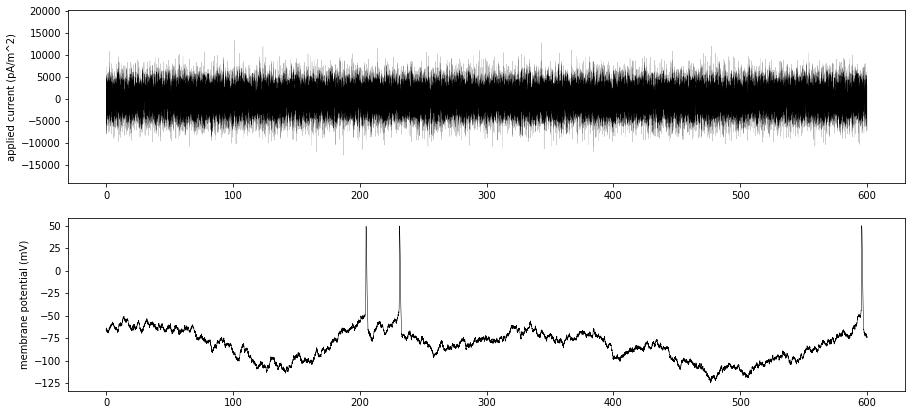

In [34]:
figure(figsize=(15, 7))
subplot(211)
# input current
plot(statemon_for_noise_test.t/ms, statemon_for_noise_test.I_app[0]/(1e-12*amp), color='k', linewidth=0.1)
ylabel('applied current (pA/m^2)')
ylim(1.5*min(statemon_for_noise_test.I_app[0]/(1e-12*amp)), 1.5*max(statemon_for_noise_test.I_app[0]/(1e-12*amp)))

subplot(212)
# Membrane potential
plot(statemon_for_noise_test.t/ms, statemon_for_noise_test.v[0]/mV, color='k', linewidth=0.5)
ylabel('membrane potential (mV)')

show()

The needed I_det is 10 times higher now than before (with surface scaling), I assume this is because the timestep is smaller now (in the original notebook the timestep of the `NetworkOperation` was 1 ms (by accident), so I suspect that the influence of the deflections is much smaller now with 100 times tinier duration).

We can see that the membrane potential trace looks realistic, but this kind of input is very difficult to regulate.

### Whole network now:

We first make lists with the noisy current and save it to a local file so it does not have to be run again later (it is slow)

In [37]:
import random as rand

noise_fac = 3000*1e-12*amp/(meter**2) # ξ(τ)
base = 25e-12*amp/(meter**2) # I^det (t)

current_for_all_thm = []

for neuron in range(num_thm):
    noise_n = [(base + noise_fac * np.random.normal(0, 1)) 
                         for i in range(int(simulation_duration/defaultclock.dt))] 
    current_for_all_thm.append(noise_n)

In [38]:
hdf5_file_name = 'noisy_current_3.h5'

with h5py.File(hdf5_file_name, 'w') as hdf_file: # write only mode
    hdf_file.create_dataset('current_for_all_thm', data=current_for_all_thm/(amp/(meter**2)))

The thalamic neurons will be directly stimulated in the equations now:

In [16]:
# Set the input from current list
hdf5_file_name = 'noisy_current_3.h5'
with h5py.File(hdf5_file_name, 'r') as hdf_file: # read only mode
    current_for_all_thm = hdf_file['current_for_all_thm'][:]*1*amp/(meter**2)
    
current_for_all_thm = rot90(current_for_all_thm)
    
stimulus = TimedArray(current_for_all_thm, dt=0.01*ms)

In [17]:
eqs_HH_thm_with_stim = '''
dv/dt = (IK + INa + IM + I_leak+ I_app)/Cm  : volt

I = IK + INa + IM + I_leak+ I_app : amp * meter**-2

I_app = stimulus(t, i) : amp * meter**-2

dn/dt = alpha_n * (1-n) - beta_n * n: 1
dm/dt = alpha_m * (1-m) - beta_m * m : 1
dh/dt = alpha_h * (1-h) - beta_h * h: 1
dp/dt = (p_inf - p)/tau_p : 1

alpha_n = -0.0320/mV*(v-I_V_T-15.0*mV) / (exp( -(v-I_V_T - 15.0*mV)/(5.0*mV)) - 1) * 1/msecond : Hz     
beta_n = 0.50 * exp( -(v-I_V_T - 10.0*mV)/(40.0*mV))*1/msecond : Hz
alpha_m =  -0.32/mV*(v-I_V_T-13.*mV) / (exp(-(v-I_V_T-13.*mV)/(4.*mV))-1)*1/msecond:Hz
beta_m = ( 0.28/mV * ((v-I_V_T-40.*mV))) / (exp((v-I_V_T-40.*mV)/(5.*mV))-1 ) *1/msecond : Hz
alpha_h = 0.128 * exp(-(v-I_V_T-17.*mV)/(18.*mV)) *1/msecond : Hz
beta_h = 4./(1.+exp(-(v-I_V_T-40.*mV)/(5.*mV))) *1/msecond : Hz
p_inf = 1 / (1.+exp(-(v+35.*mV)/(10.*mV))) : 1
tau_p = I_tau_max_M /( (3.3*exp((v+35.*mV)/(20.*mV)) + exp(-(v+35.*mV)/(20.*mV)))) : second

IK    = -E_gK * n**4 *(v-EK) : amp * meter**-2
INa   = -E_gNa*m**3*h*(v-ENa)   : amp * meter**-2
IM    = -E_gM *p *(v-E_M)  : amp * meter**-2

I_leak = -E_gleak*(v-E_Eleak): amp * meter**-2

ds/dt = -s/taud_AMPA + 1/2 * (1 + tanh(v/slope_AMPA)) * (1-s)/taur_AMPA : 1 
'''

Create a new neurongroup and synapses for the thm with these new equations:

In [54]:
thm_group_poisson = NeuronGroup(num_thm, eqs_HH_thm_with_stim,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler')

IC = {'v':-65*mV}
thm_group_poisson.set_states(IC)

Restoring the neurongroups etc. from the previous run is not possible, so I redefine them again here with different names:

In [55]:
# This is the same as seen previously, but with different variable names

# Make the pools of neurons
E_pool_L4_poisson = NeuronGroup(N_E_L4, eqs_HH_E,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

I_pool_L4_poisson = NeuronGroup(N_I_L4, eqs_HH_I,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

E_pool_L3_poisson = NeuronGroup(N_E_L3, eqs_HH_E,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

I_pool_L3_poisson = NeuronGroup(N_I_L3, eqs_HH_I,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

E_pool_L4_poisson.set_states(IC)
I_pool_L4_poisson.set_states(IC)
E_pool_L3_poisson.set_states(IC)
I_pool_L3_poisson.set_states(IC)

# Synapses L4
synEE_L4_poisson = Synapses(E_pool_L4_poisson, E_pool_L4_poisson, 's_in_EE_post = w_L4E_L4E*weight_s*s_pre:1 (summed)') 
synEI_L4_poisson = Synapses(E_pool_L4_poisson, I_pool_L4_poisson, 's_in_EI_post = w_L4E_L4I*weight_s*s_pre:1 (summed)') 
synIE_L4_poisson = Synapses(I_pool_L4_poisson, E_pool_L4_poisson, 'z_in_IE_post = w_L4I_L4E*weight_z*z_pre:1 (summed)') 
synII_L4_poisson = Synapses(I_pool_L4_poisson, I_pool_L4_poisson, 'z_in_II_post = w_L4I_L4I*weight_z*z_pre:1 (summed)')

# Synapses L3
synEE_L3_poisson = Synapses(E_pool_L3_poisson, E_pool_L3_poisson, 's_in_EE_post = w_L3E_L3E*weight_s*s_pre:1 (summed)') 
synEI_L3_poisson = Synapses(E_pool_L3_poisson, I_pool_L3_poisson, 's_in_EI_post = w_L3E_L3I*weight_s*s_pre:1 (summed)') 
synIE_L3_poisson = Synapses(I_pool_L3_poisson, E_pool_L3_poisson, 'z_in_IE_post = w_L3I_L3E*weight_z*z_pre:1 (summed)') 
synII_L3_poisson = Synapses(I_pool_L3_poisson, I_pool_L3_poisson, 'z_in_II_post = w_L3I_L3I*weight_z*z_pre:1 (summed)') 

#synapses for interlayer connections between L3 and L4
synEE_inter_poisson = Synapses(E_pool_L4_poisson, E_pool_L3_poisson, 's_in_EE_inter_post = w_L4E_L3E*weight_s*s_pre:1 (summed)') 
synIE_inter_poisson = Synapses(I_pool_L4_poisson, E_pool_L3_poisson, 'z_in_IE_inter_post = w_L4I_L3E*weight_z*z_pre:1 (summed)') 
synEI_inter_poisson = Synapses(E_pool_L4_poisson, I_pool_L3_poisson, 's_in_EI_inter_post = w_L4E_L3I*weight_s*s_pre:1 (summed)') 


pos_listEE_L4 = prob_matrix(N_E_L4, N_E_L4, pEE_L4)
for pre_n in range(N_E_L4): #loop over pre_syn neuron
    for post_n in range(N_E_L4): # now loop post syn neuron
        if pos_listEE_L4[pre_n][post_n] == 1 and pre_n != post_n:
            synEE_L4_poisson.connect(i=pre_n, j=post_n)
            
pos_listEI_L4 = prob_matrix(N_E_L4, N_I_L4, pEI_L4)
for pre_n in range(N_E_L4): 
    for post_n in range(N_I_L4):
        if pos_listEI_L4[pre_n][post_n] == 1:
            synEI_L4_poisson.connect(i=pre_n, j=post_n)
            
pos_listIE_L4 = prob_matrix(N_I_L4, N_E_L4, pIE_L4)
for pre_n in range(N_I_L4): 
    for post_n in range(N_E_L4):
        if pos_listIE_L4[pre_n][post_n] == 1:
            synIE_L4_poisson.connect(i=pre_n, j=post_n)
            
pos_listII_L4 = prob_matrix(N_I_L4, N_I_L4, pII_L4)
for pre_n in range(N_I_L4): 
    for post_n in range(N_I_L4):
        if pos_listII_L4[pre_n][post_n] == 1 and pre_n != post_n:
            synII_L4_poisson.connect(i=pre_n, j=post_n)
            
# L3 cons            
pos_listEE_L3 = prob_matrix(N_E_L3, N_E_L3, pEE_L3)
for pre_n in range(N_E_L3): #loop over pre_syn neuron
    for post_n in range(N_E_L3): # now loop post syn neuron
        if pos_listEE_L3[pre_n][post_n] == 1 and pre_n != post_n:
            synEE_L3_poisson.connect(i=pre_n, j=post_n)
            
pos_listEI_L3 = prob_matrix(N_E_L3, N_I_L3, pEI_L3)
for pre_n in range(N_E_L3): 
    for post_n in range(N_I_L3):
        if pos_listEI_L3[pre_n][post_n] == 1:
            synEI_L3_poisson.connect(i=pre_n, j=post_n)
            
pos_listIE_L3 = prob_matrix(N_I_L3, N_E_L3, pIE_L3)
for pre_n in range(N_I_L3): 
    for post_n in range(N_E_L3):
        if pos_listIE_L3[pre_n][post_n] == 1:
            synIE_L3_poisson.connect(i=pre_n, j=post_n)
            
pos_listII_L3 = prob_matrix(N_I_L3, N_I_L3, pII_L3)
for pre_n in range(N_I_L3): 
    for post_n in range(N_I_L3):
        if pos_listII_L3[pre_n][post_n] == 1 and pre_n != post_n:
            synII_L3_poisson.connect(i=pre_n, j=post_n)  
            
# interlayer cons
pos_listEE_inter = prob_matrix(N_E_L4, N_E_L3, pEE_inter)
for pre_n in range(N_E_L4): 
    for post_n in range(N_E_L3):
        if pos_listEE_inter[pre_n][post_n] == 1 and pre_n != post_n:
            synEE_inter_poisson.connect(i=pre_n, j=post_n) 
            
pos_listEI_inter = prob_matrix(N_E_L4, N_I_L3, pEE_inter)
for pre_n in range(N_E_L4): 
    for post_n in range(N_I_L3):
        if pos_listEI_inter[pre_n][post_n] == 1 and pre_n != post_n:
            synEI_inter_poisson.connect(i=pre_n, j=post_n) 
            
pos_listIE_inter = prob_matrix(N_I_L4, N_E_L3, pEE_inter)
for pre_n in range(N_I_L4): 
    for post_n in range(N_E_L3):
        if pos_listIE_inter[pre_n][post_n] == 1 and pre_n != post_n:
            synIE_inter_poisson.connect(i=pre_n, j=post_n) 

# Monitors
# Layer 4
M_E_L4_poisson = StateMonitor(E_pool_L4_poisson, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
M_I_L4_poisson = StateMonitor(I_pool_L4_poisson, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
spikemon_E_L4_poisson = SpikeMonitor(E_pool_L4_poisson, variables='v')
spikemon_I_L4_poisson = SpikeMonitor(I_pool_L4_poisson, variables='v')

# Layer 3
M_E_L3_poisson = StateMonitor(E_pool_L3_poisson, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
M_I_L3_poisson = StateMonitor(I_pool_L3_poisson, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
spikemon_E_L3_poisson = SpikeMonitor(E_pool_L3_poisson, variables='v')
spikemon_I_L3_poisson = SpikeMonitor(I_pool_L3_poisson, variables='v')

In [56]:
# Synapses for VPM connections (thm -> L4)
syn_thm_E_poisson = Synapses(thm_group_poisson, E_pool_L4_poisson, 's_in_VPM_post = w_thm_L4E*weight_thm*s_pre:1 (summed)')
syn_thm_I_poisson = Synapses(thm_group_poisson, I_pool_L4_poisson, 's_in_VPM_post = w_thm_L4I*weight_thm*s_pre:1 (summed)')

# connect L4 to the thalamus input            
pos_list_thmE = prob_matrix(num_thm, N_E_L4, pVPM_E)
for pre_n in range(num_thm): 
    for post_n in range(N_E_L4): 
        if pos_list_thmE[pre_n][post_n] == 1 and pre_n != post_n:
            syn_thm_E_poisson.connect(i=pre_n, j=post_n)
            
pos_list_thmI = prob_matrix(num_thm, N_I_L4, pVPM_I)
for pre_n in range(num_thm): 
    for post_n in range(N_I_L4): 
        if pos_list_thmI[pre_n][post_n] == 1 and pre_n != post_n:
            syn_thm_I_poisson.connect(i=pre_n, j=post_n)

In [57]:
statemon_thm_poisson = StateMonitor(thm_group_poisson, ('v', 'I', 'I_app'), record=True)
spikemon_thm_poisson = SpikeMonitor(thm_group_poisson, variables='v')

In [61]:
#network_all_layers_pulse_input.remove(spikemon_thm, statemon_thm)
#network_all_layers_pulse_input.restore()

In [58]:
network_all_layers_poisson = Network(E_pool_L4_poisson, I_pool_L4_poisson, E_pool_L3_poisson,
                                     I_pool_L3_poisson, thm_group_poisson,
                                        M_E_L4_poisson, M_I_L4_poisson, spikemon_E_L4_poisson,
                                     spikemon_I_L4_poisson, M_E_L3_poisson, M_I_L3_poisson, spikemon_E_L3_poisson,
                                        spikemon_I_L3_poisson, spikemon_thm_poisson, statemon_thm_poisson,
                                        syn_thm_E_poisson, syn_thm_I_poisson, synEI_inter_poisson, 
                                     synIE_inter_poisson, synEE_inter_poisson,
                                        synII_L3_poisson, synIE_L3_poisson, synEI_L3_poisson, 
                                     synEE_L3_poisson, synII_L4_poisson, synIE_L4_poisson, 
                                        synEI_L4_poisson, synEE_L4_poisson)
# this is horrible

network_all_layers_poisson.store()

In [59]:
network_all_layers_poisson.run(simulation_duration)

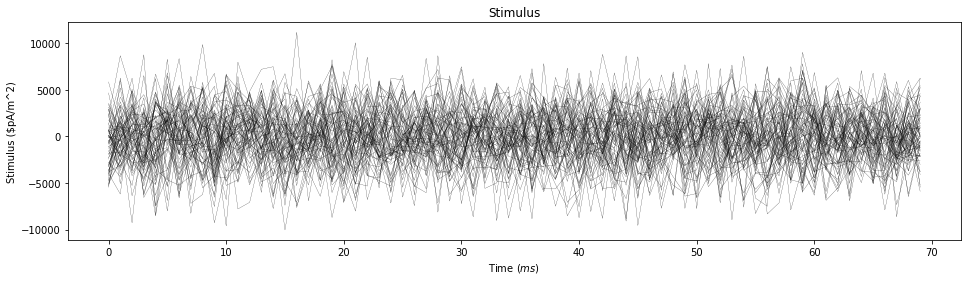

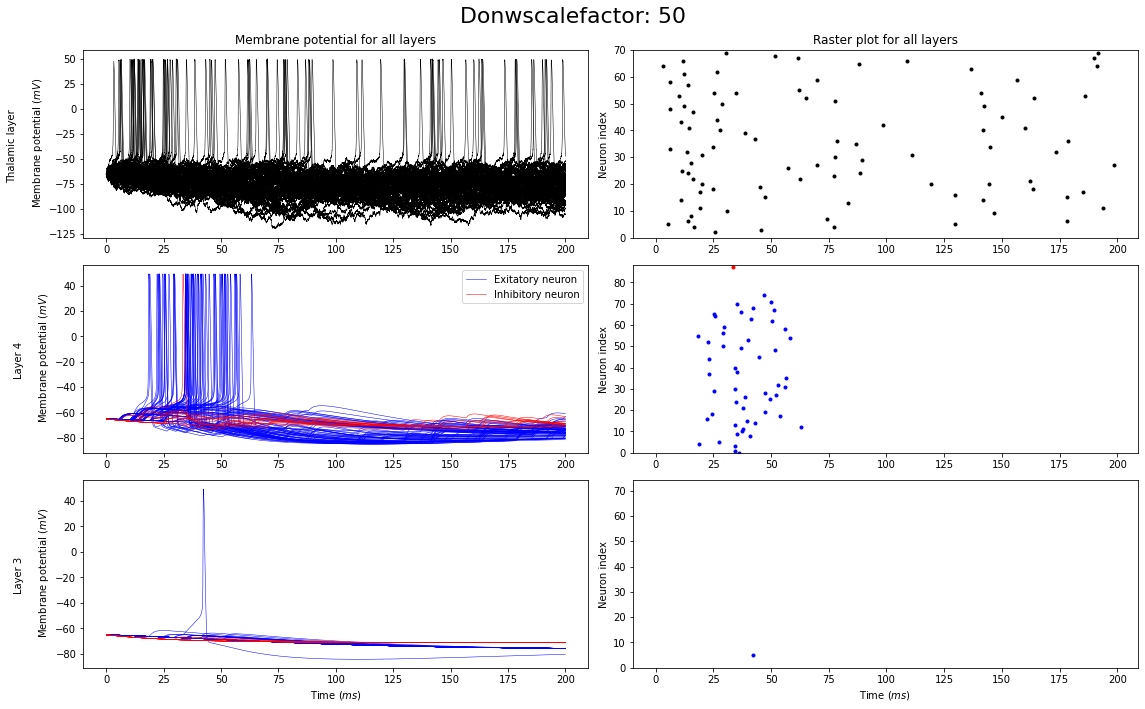

In [60]:
# plot input to thm first
figure(figsize=(16, 4))
title('Stimulus')
for i in range(num_thm):
    plot(current_for_all_thm[i]/(1e-12), linewidth=0.2, c='k')
xlabel('Time ($ms$)')  
ylabel('Stimulus ($pA/m^2)')
show()

# Plotting the spikes
figure(figsize=(16, 10))

suptitle('Donwscalefactor: {}'.format(f_downscale), fontsize=22)

plt.subplot(321)
title('Membrane potential for all layers')
for neuron in range(0, num_thm):
    plot(statemon_thm_poisson.t/ms, statemon_thm_poisson.v[neuron]/mV,  c='k', linewidth = 0.5)
ylabel('Thalamic layer \n\n Membrane potential ($mV$)')

plt.subplot(322)
# mark the first and last time point so the axes align
time_p = np.arange(0, (simulation_duration)/ms)
plt.scatter(time_p[-1], 5, c='w')
plt.scatter(time_p[0], 5, c='w')
ylim(0, num_thm)
title('Raster plot for all layers')
data_thm = spikemon_thm_poisson.spike_trains()
neurons = np.arange(0, num_thm)
for neuron in range(num_thm):
    for spike in range(len(data_thm[neuron])):
        plt.scatter(data_thm[neuron][spike]/ms, neuron, c='k', marker='.')
ylabel('Neuron index')

plt.subplot(323)
plot(M_E_L4_poisson.t/ms, M_E_L4_poisson.v[0]/mV, label='Exitatory neuron',  c='b', linewidth = 0.5) #plot the first ones seperately for the legend
plot(M_I_L4_poisson.t/ms, M_I_L4_poisson.v[0]/mV, label='Inhibitory neuron', c='r', linewidth = 0.5)
for neuron in range(1, N_E_L4):
    plot(M_E_L4_poisson.t/ms, M_E_L4_poisson.v[neuron]/mV,  c='b', linewidth = 0.5)
for neuron in range(1, N_I_L4):
    plot(M_I_L4_poisson.t/ms, M_I_L4_poisson.v[neuron]/mV, c='r', linewidth = 0.5)
ylabel('Layer 4 \n\n Membrane potential ($mV$)')
#legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
legend()

plt.subplot(324)
time = np.arange(0, (simulation_duration)/ms)
plt.scatter(time_p[-1], 5, c='w')
plt.scatter(time_p[0], 5, c='w')
ylim(0, N_L4)
dataE = spikemon_E_L4_poisson.spike_trains()
dataI = spikemon_I_L4_poisson.spike_trains()
neurons = np.arange(0, N_E_L4)
for neuron in range(N_E_L4):
    for spike in range(len(dataE[neuron])):
        plt.scatter(dataE[neuron][spike]/ms, neuron, c='b', marker='.')
for neuron in range(N_I_L4):
    for spike in range(len(dataI[neuron])):
        plt.scatter(dataI[neuron][spike]/ms, neuron+N_E_L4, c='r', marker='.')
ylabel('Neuron index')


plt.subplot(325)
#title('L3')
for neuron in range(0, N_E_L3):
    plot(M_E_L3_poisson.t/ms, M_E_L3_poisson.v[neuron]/mV,  c='b', linewidth = 0.5)
for neuron in range(0, N_I_L3):
    plot(M_I_L3_poisson.t/ms, M_I_L3_poisson.v[neuron]/mV, c='r', linewidth = 0.5) 
ylabel('Layer 3 \n\n Membrane potential ($mV$)')
xlabel('Time ($ms$)')


plt.subplot(326)
plt.scatter(time_p[-1], 5, c='w')
plt.scatter(time_p[0], 5, c='w')
ylim(0, N_L3)
dataE = spikemon_E_L3_poisson.spike_trains()
dataI = spikemon_I_L3_poisson.spike_trains()
neurons = np.arange(0, N_E_L3)
for neuron in range(N_E_L3):
    for spike in range(len(dataE[neuron])):
        plt.scatter(dataE[neuron][spike]/ms, neuron, c='b', marker='.')
for neuron in range(N_I_L3):
    for spike in range(len(dataI[neuron])):
        plt.scatter(dataI[neuron][spike]/ms, neuron+N_E_L3, c='r', marker='.')     
xlabel('Time ($ms$)')  
ylabel('Neuron index')


plt.tight_layout()
plt.show()

## EPSC-like input to the thalamus

Lastly, because the noisy input is difficult to regulate, we create traces of 'EPSCs' to stimulate the thalamic neurons with. For this, we create lists of currents that have EPSC-like pulses, where each one will cause one action potential in the stimulated neuron. This makes the behaviour of the thalamus easy to regulate.

First we create the shape of one EPSC (based on gaussian distribution with error function to shape it):

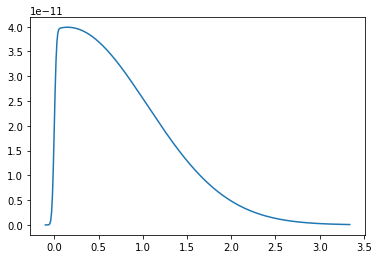

In [18]:
def bump(x, m=0.1, s=0.6, a=50, size = 40e-12*amp/(meter**2)):
    coefficient = 3/2*1 / ((s * (8 * pi) ** (1/2)))
    exponent_term = exp(-0.5 * ((x/1.5 - m) / s) ** 2)
    erf_term = 1 + erf((a * x) / (2 ** (1/2)))

    return size * coefficient * exponent_term * erf_term

x_values = arange(-0.1, 3.35, 0.01)
bump_shape = [bump(i) for i in x_values]
plot(x_values, bump_shape)

The pulse is stored in an array with stepsize of 0.1 (same as `defaultclock.dt` stepsize in Brian), so the pulse takes about 3 ms (short enough to not cause a 2nd AP).

Now we make a current array for each of the 70 thm 'neurons'. These traces are the same, but shifted in time a bit and some shifted a lot, so it is still noisy.

In [63]:
# running takes long !

duration = 1000*ms # make it longer so it can be used in longer simulations too

times = arange(0, int(duration/ms), 0.01)
bump_times = [30, 280, 520, 700, 890] # change ?

# make a list of zeros first and add the pulses later
currents = [[0*1e-12*amp/(meter**2)*i for i in range(int(duration/ms*100))] for j in range(num_thm)]

# total for checking the distribution
total = [0*1e-12*amp/(meter**2)*i for i in range(int(duration/ms*100))]

for neuron in range(num_thm):
    # some neurons should be shifted more, 80% around the same time
    if neuron < 0.8*num_thm:
        shift = np.random.normal(0, 5.5)
    else:
        shift = np.random.normal(0, 200)
        if -1*shift >= bump_times[0]:
            shift = -1*shift
            
    for bump_time in bump_times:
        if bump_time < duration/ms:
            for i in range(len(bump_shape)):
                if int(bump_time+shift)*100+i >=0 and int(bump_time+shift)*100+i <= duration/ms*100:
                    currents[neuron][int(bump_time+shift)*100+i] = bump_shape[i]
           #         total[int(bump_time+shift)*100+i] += bump_shape[i]


In [ ]:
# takes really long?

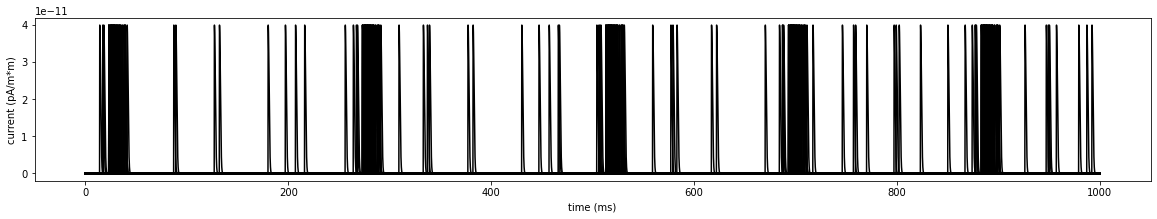

In [75]:
figure(figsize=(20,3))
for neuron in range(num_thm):
    plot(times, currents[neuron]/(amp/meter**2), color = 'k')
xlabel('time (ms)')
ylabel('current (pA/m*m)')
show()

Save again to a HDF5 file so it doesn't have to run again later (its slow)

In [ ]:
hdf5_file_name = 'currents_thm_test_14.h5'

with h5py.File(hdf5_file_name, 'w') as hdf_file: # 'w' means only writing
    hdf_file.create_dataset('currents', data=currents)
    hdf_file.create_dataset('total', data=total)

Now we implement it into a network again. The network is the same as the previous, only because the `stimulus(t, i)` in the equations for the thalamus is different, the thalamic neurons have to be redefined and thus also the whole network. The code below will be the same as previous apart of the naming of the variables (and the stimulus).

In [18]:
# Set the input from current list
hdf5_file_name = 'currents_thm_test_13.h5'
with h5py.File(hdf5_file_name, 'r') as hdf_file: # read only mode
    current_for_EPSC = hdf_file['currents'][:]*1*amp/(meter**2)*400
    
current_for_EPSC = rot90(current_for_EPSC)
    
stimulus_EPSC = TimedArray(current_for_EPSC, dt=0.01*ms)

In [19]:
eqs_HH_for_EPSC = '''
dv/dt = (IK + INa + IM + I_leak+ I_app)/Cm  : volt

I = IK + INa + IM + I_leak+ I_app : amp * meter**-2

I_app = stimulus_EPSC(t, i) : amp * meter**-2

dn/dt = alpha_n * (1-n) - beta_n * n: 1
dm/dt = alpha_m * (1-m) - beta_m * m : 1
dh/dt = alpha_h * (1-h) - beta_h * h: 1
dp/dt = (p_inf - p)/tau_p : 1

alpha_n = -0.0320/mV*(v-I_V_T-15.0*mV) / (exp( -(v-I_V_T - 15.0*mV)/(5.0*mV)) - 1) * 1/msecond : Hz     
beta_n = 0.50 * exp( -(v-I_V_T - 10.0*mV)/(40.0*mV))*1/msecond : Hz
alpha_m =  -0.32/mV*(v-I_V_T-13.*mV) / (exp(-(v-I_V_T-13.*mV)/(4.*mV))-1)*1/msecond:Hz
beta_m = ( 0.28/mV * ((v-I_V_T-40.*mV))) / (exp((v-I_V_T-40.*mV)/(5.*mV))-1 ) *1/msecond : Hz
alpha_h = 0.128 * exp(-(v-I_V_T-17.*mV)/(18.*mV)) *1/msecond : Hz
beta_h = 4./(1.+exp(-(v-I_V_T-40.*mV)/(5.*mV))) *1/msecond : Hz
p_inf = 1 / (1.+exp(-(v+35.*mV)/(10.*mV))) : 1
tau_p = I_tau_max_M /( (3.3*exp((v+35.*mV)/(20.*mV)) + exp(-(v+35.*mV)/(20.*mV)))) : second

IK    = -E_gK * n**4 *(v-EK) : amp * meter**-2
INa   = -E_gNa*m**3*h*(v-ENa)   : amp * meter**-2
IM    = -E_gM *p *(v-E_M)  : amp * meter**-2

I_leak = -E_gleak*(v-E_Eleak): amp * meter**-2

ds/dt = -s/taud_AMPA + 1/2 * (1 + tanh(v/slope_AMPA)) * (1-s)/taur_AMPA : 1 
'''

In [20]:
thm_group_EPSC = NeuronGroup(num_thm, eqs_HH_for_EPSC,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler')

IC = {'v':-65*mV}
thm_group_EPSC.set_states(IC)

In [21]:
# This is the same as seen previously, but with different variable names

# Make the pools of neurons
E_pool_L4_EPSC = NeuronGroup(N_E_L4, eqs_HH_E,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

I_pool_L4_EPSC = NeuronGroup(N_I_L4, eqs_HH_I,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

E_pool_L3_EPSC = NeuronGroup(N_E_L3, eqs_HH_E,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

I_pool_L3_EPSC = NeuronGroup(N_I_L3, eqs_HH_I,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

E_pool_L4_EPSC.set_states(IC)
I_pool_L4_EPSC.set_states(IC)
E_pool_L3_EPSC.set_states(IC)
I_pool_L3_EPSC.set_states(IC)

# Synapses L4
synEE_L4_EPSC = Synapses(E_pool_L4_EPSC, E_pool_L4_EPSC, 's_in_EE_post = w_L4E_L4E*weight_s*s_pre:1 (summed)') 
synEI_L4_EPSC = Synapses(E_pool_L4_EPSC, I_pool_L4_EPSC, 's_in_EI_post = w_L4E_L4I*weight_s*s_pre:1 (summed)') 
synIE_L4_EPSC = Synapses(I_pool_L4_EPSC, E_pool_L4_EPSC, 'z_in_IE_post = w_L4I_L4E*weight_z*z_pre:1 (summed)') 
synII_L4_EPSC = Synapses(I_pool_L4_EPSC, I_pool_L4_EPSC, 'z_in_II_post = w_L4I_L4I*weight_z*z_pre:1 (summed)')

# Synapses L3
synEE_L3_EPSC = Synapses(E_pool_L3_EPSC, E_pool_L3_EPSC, 's_in_EE_post = w_L3E_L3E*weight_s*s_pre:1 (summed)') 
synEI_L3_EPSC = Synapses(E_pool_L3_EPSC, I_pool_L3_EPSC, 's_in_EI_post = w_L3E_L3I*weight_s*s_pre:1 (summed)') 
synIE_L3_EPSC = Synapses(I_pool_L3_EPSC, E_pool_L3_EPSC, 'z_in_IE_post = w_L3I_L3E*weight_z*z_pre:1 (summed)') 
synII_L3_EPSC = Synapses(I_pool_L3_EPSC, I_pool_L3_EPSC, 'z_in_II_post = w_L3I_L3I*weight_z*z_pre:1 (summed)') 

#synapses for interlayer connections between L3 and L4
synEE_inter_EPSC = Synapses(E_pool_L4_EPSC, E_pool_L3_EPSC, 's_in_EE_inter_post = w_L4E_L3E*weight_s*s_pre:1 (summed)') 
synIE_inter_EPSC = Synapses(I_pool_L4_EPSC, E_pool_L3_EPSC, 'z_in_IE_inter_post = w_L4I_L3E*weight_z*z_pre:1 (summed)') 
synEI_inter_EPSC = Synapses(E_pool_L4_EPSC, I_pool_L3_EPSC, 's_in_EI_inter_post = w_L4E_L3I*weight_s*s_pre:1 (summed)') 


pos_listEE_L4 = prob_matrix(N_E_L4, N_E_L4, pEE_L4)
for pre_n in range(N_E_L4): #loop over pre_syn neuron
    for post_n in range(N_E_L4): # now loop post syn neuron
        if pos_listEE_L4[pre_n][post_n] == 1 and pre_n != post_n:
            synEE_L4_EPSC.connect(i=pre_n, j=post_n)
            
pos_listEI_L4 = prob_matrix(N_E_L4, N_I_L4, pEI_L4)
for pre_n in range(N_E_L4): 
    for post_n in range(N_I_L4):
        if pos_listEI_L4[pre_n][post_n] == 1:
            synEI_L4_EPSC.connect(i=pre_n, j=post_n)
            
pos_listIE_L4 = prob_matrix(N_I_L4, N_E_L4, pIE_L4)
for pre_n in range(N_I_L4): 
    for post_n in range(N_E_L4):
        if pos_listIE_L4[pre_n][post_n] == 1:
            synIE_L4_EPSC.connect(i=pre_n, j=post_n)
            
pos_listII_L4 = prob_matrix(N_I_L4, N_I_L4, pII_L4)
for pre_n in range(N_I_L4): 
    for post_n in range(N_I_L4):
        if pos_listII_L4[pre_n][post_n] == 1 and pre_n != post_n:
            synII_L4_EPSC.connect(i=pre_n, j=post_n)
            
# L3 cons            
pos_listEE_L3 = prob_matrix(N_E_L3, N_E_L3, pEE_L3)
for pre_n in range(N_E_L3): #loop over pre_syn neuron
    for post_n in range(N_E_L3): # now loop post syn neuron
        if pos_listEE_L3[pre_n][post_n] == 1 and pre_n != post_n:
            synEE_L3_EPSC.connect(i=pre_n, j=post_n)
            
pos_listEI_L3 = prob_matrix(N_E_L3, N_I_L3, pEI_L3)
for pre_n in range(N_E_L3): 
    for post_n in range(N_I_L3):
        if pos_listEI_L3[pre_n][post_n] == 1:
            synEI_L3_EPSC.connect(i=pre_n, j=post_n)
            
pos_listIE_L3 = prob_matrix(N_I_L3, N_E_L3, pIE_L3)
for pre_n in range(N_I_L3): 
    for post_n in range(N_E_L3):
        if pos_listIE_L3[pre_n][post_n] == 1:
            synIE_L3_EPSC.connect(i=pre_n, j=post_n)
            
pos_listII_L3 = prob_matrix(N_I_L3, N_I_L3, pII_L3)
for pre_n in range(N_I_L3): 
    for post_n in range(N_I_L3):
        if pos_listII_L3[pre_n][post_n] == 1 and pre_n != post_n:
            synII_L3_EPSC.connect(i=pre_n, j=post_n)  
            
# interlayer cons
pos_listEE_inter = prob_matrix(N_E_L4, N_E_L3, pEE_inter)
for pre_n in range(N_E_L4): 
    for post_n in range(N_E_L3):
        if pos_listEE_inter[pre_n][post_n] == 1 and pre_n != post_n:
            synEE_inter_EPSC.connect(i=pre_n, j=post_n) 
            
pos_listEI_inter = prob_matrix(N_E_L4, N_I_L3, pEE_inter)
for pre_n in range(N_E_L4): 
    for post_n in range(N_I_L3):
        if pos_listEI_inter[pre_n][post_n] == 1 and pre_n != post_n:
            synEI_inter_EPSC.connect(i=pre_n, j=post_n) 
            
pos_listIE_inter = prob_matrix(N_I_L4, N_E_L3, pEE_inter)
for pre_n in range(N_I_L4): 
    for post_n in range(N_E_L3):
        if pos_listIE_inter[pre_n][post_n] == 1 and pre_n != post_n:
            synIE_inter_EPSC.connect(i=pre_n, j=post_n) 

# Monitors
# Layer 4
M_E_L4_EPSC = StateMonitor(E_pool_L4_EPSC, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
M_I_L4_EPSC = StateMonitor(I_pool_L4_EPSC, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
spikemon_E_L4_EPSC = SpikeMonitor(E_pool_L4_EPSC, variables='v')
spikemon_I_L4_EPSC = SpikeMonitor(I_pool_L4_EPSC, variables='v')

# Layer 3
M_E_L3_EPSC = StateMonitor(E_pool_L3_EPSC, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
M_I_L3_EPSC = StateMonitor(I_pool_L3_EPSC, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
spikemon_E_L3_EPSC = SpikeMonitor(E_pool_L3_EPSC, variables='v')
spikemon_I_L3_EPSC = SpikeMonitor(I_pool_L3_EPSC, variables='v')


In [22]:
# Synapses for VPM connections (thm -> L4)
syn_thm_E_EPSC = Synapses(thm_group_EPSC, E_pool_L4_EPSC, 's_in_VPM_post = w_thm_L4E*weight_thm*s_pre:1 (summed)')
syn_thm_I_EPSC = Synapses(thm_group_EPSC, I_pool_L4_EPSC, 's_in_VPM_post = w_thm_L4I*weight_thm*s_pre:1 (summed)')


# connect L4 to the thalamus input            
pos_list_thmE = prob_matrix(num_thm, N_E_L4, pVPM_E)
for pre_n in range(num_thm): 
    for post_n in range(N_E_L4): 
        if pos_list_thmE[pre_n][post_n] == 1 and pre_n != post_n:
            syn_thm_E_EPSC.connect(i=pre_n, j=post_n)
            
pos_list_thmI = prob_matrix(num_thm, N_I_L4, pVPM_I)
for pre_n in range(num_thm): 
    for post_n in range(N_I_L4): 
        if pos_list_thmI[pre_n][post_n] == 1 and pre_n != post_n:
            syn_thm_I_EPSC.connect(i=pre_n, j=post_n)


In [23]:
statemon_thm_EPSC = StateMonitor(thm_group_EPSC, ('v', 'I', 'I_app'), record=True)
spikemon_thm_EPSC = SpikeMonitor(thm_group_EPSC, variables='v')

In [24]:
network_all_layers_EPSC = Network(E_pool_L4_EPSC, I_pool_L4_EPSC, E_pool_L3_EPSC,
                                     I_pool_L3_EPSC, thm_group_EPSC,
                                        M_E_L4_EPSC, M_I_L4_EPSC, spikemon_E_L4_EPSC,
                                     spikemon_I_L4_EPSC, M_E_L3_EPSC, M_I_L3_EPSC, spikemon_E_L3_EPSC,
                                        spikemon_I_L3_EPSC, spikemon_thm_EPSC, statemon_thm_EPSC,
                                        syn_thm_E_EPSC, syn_thm_I_EPSC, synEI_inter_EPSC, 
                                     synIE_inter_EPSC, synEE_inter_EPSC,
                                        synII_L3_EPSC, synIE_L3_EPSC, synEI_L3_EPSC, 
                                     synEE_L3_EPSC, synII_L4_EPSC, synIE_L4_EPSC, 
                                        synEI_L4_EPSC, synEE_L4_EPSC)

network_all_layers_EPSC.store()

In [28]:
extra_duration = 1

In [25]:
network_all_layers_EPSC.run(simulation_duration*extra_duration)

WARNING    <ipython-input-29-d34c35739915>:124: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
 [py.warnings]
WARNING    C:\Python3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]


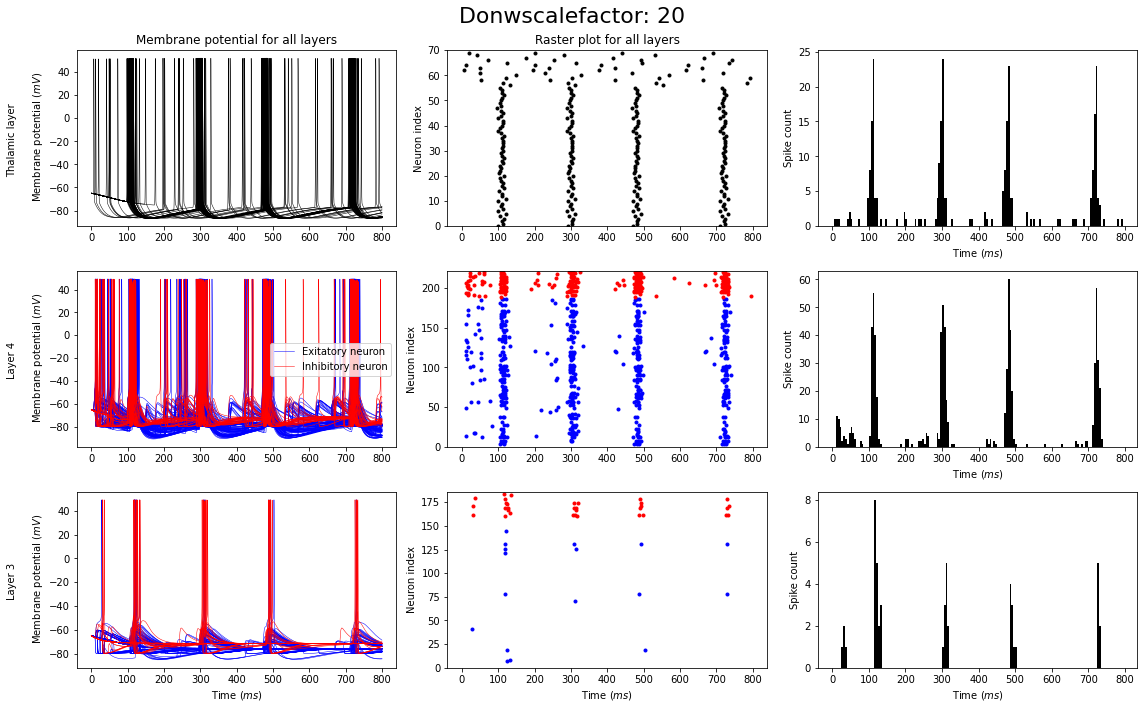

In [29]:
# PTSH are added now

# Plotting the spikes
figure(figsize=(16, 10))

suptitle('Donwscalefactor: {}'.format(f_downscale), fontsize=22)

plt.subplot(331)
title('Membrane potential for all layers')
for neuron in range(0, num_thm):
    plot(statemon_thm_EPSC.t/ms, statemon_thm_EPSC.v[neuron]/mV,  c='k', linewidth = 0.5)
ylabel('Thalamic layer \n\n Membrane potential ($mV$)')

plt.subplot(332)
# mark the first and last time point so the axes align
time_p = np.arange(0, (simulation_duration)/ms)
plt.scatter(time_p[-1], 5, c='w')
plt.scatter(time_p[0], 5, c='w')
ylim(0, num_thm)
title('Raster plot for all layers')
data_thm = spikemon_thm_EPSC.spike_trains()
neurons = np.arange(0, num_thm)
for neuron in range(num_thm):
    for spike in range(len(data_thm[neuron])):
        plt.scatter(data_thm[neuron][spike]/ms, neuron, c='k', marker='.')
ylabel('Neuron index')

plt.subplot(333)
spike_data = []
data = spikemon_thm_EPSC.spike_trains()

for i in range(num_thm):
    spike_data.extend(data[i]/ms)

binwidth = 5
bins = np.arange(0, simulation_duration*extra_duration/ms, binwidth)
hist(spike_data, bins=bins, color='k')
plt.xlabel('Time ($ms$)')
plt.ylabel('Spike count')

plt.subplot(334)
plot(M_E_L4_EPSC.t/ms, M_E_L4_EPSC.v[0]/mV, label='Exitatory neuron',  c='b', linewidth = 0.5) #plot the first ones seperately for the legend
plot(M_I_L4_EPSC.t/ms, M_I_L4_EPSC.v[0]/mV, label='Inhibitory neuron', c='r', linewidth = 0.5)
for neuron in range(1, N_E_L4):
    plot(M_E_L4_EPSC.t/ms, M_E_L4_EPSC.v[neuron]/mV,  c='b', linewidth = 0.5)
for neuron in range(1, N_I_L4):
    plot(M_I_L4_EPSC.t/ms, M_I_L4_EPSC.v[neuron]/mV, c='r', linewidth = 0.5)
ylabel('Layer 4 \n\n Membrane potential ($mV$)')
#legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
legend()

plt.subplot(335)
time = np.arange(0, (simulation_duration)/ms)
plt.scatter(time_p[-1], 5, c='w')
plt.scatter(time_p[0], 5, c='w')
ylim(0, N_L4)
dataE = spikemon_E_L4_EPSC.spike_trains()
dataI = spikemon_I_L4_EPSC.spike_trains()
neurons = np.arange(0, N_E_L4)
for neuron in range(N_E_L4):
    for spike in range(len(dataE[neuron])):
        plt.scatter(dataE[neuron][spike]/ms, neuron, c='b', marker='.')
for neuron in range(N_I_L4):
    for spike in range(len(dataI[neuron])):
        plt.scatter(dataI[neuron][spike]/ms, neuron+N_E_L4, c='r', marker='.')
ylabel('Neuron index')

plt.subplot(336)
spike_data = []
dataE = spikemon_E_L4_EPSC.spike_trains()
for i in range(N_E_L4):
    spike_data.extend(dataE[i]/ms)
dataI = spikemon_I_L4_EPSC.spike_trains()
for i in range(N_I_L4):
    spike_data.extend(dataI[i]/ms)
binwidth = 5
bins = np.arange(0, simulation_duration*extra_duration/ms, binwidth)
hist(spike_data, bins=bins, color='k')
plt.xlabel('Time ($ms$)')
plt.ylabel('Spike count')


plt.subplot(337)
#title('L3')
for neuron in range(0, N_E_L3):
    plot(M_E_L3_EPSC.t/ms, M_E_L3_EPSC.v[neuron]/mV,  c='b', linewidth = 0.5)
for neuron in range(0, N_I_L3):
    plot(M_I_L3_EPSC.t/ms, M_I_L3_EPSC.v[neuron]/mV, c='r', linewidth = 0.5) 
ylabel('Layer 3 \n\n Membrane potential ($mV$)')
xlabel('Time ($ms$)')


plt.subplot(338)
plt.scatter(time_p[-1], 5, c='w')
plt.scatter(time_p[0], 5, c='w')
ylim(0, N_L3)
dataE = spikemon_E_L3_EPSC.spike_trains()
dataI = spikemon_I_L3_EPSC.spike_trains()
neurons = np.arange(0, N_E_L3)
for neuron in range(N_E_L3):
    for spike in range(len(dataE[neuron])):
        plt.scatter(dataE[neuron][spike]/ms, neuron, c='b', marker='.')
for neuron in range(N_I_L3):
    for spike in range(len(dataI[neuron])):
        plt.scatter(dataI[neuron][spike]/ms, neuron+N_E_L3, c='r', marker='.')     
xlabel('Time ($ms$)')  
ylabel('Neuron index')

plt.subplot(339)
spike_data = []
dataE = spikemon_E_L3_EPSC.spike_trains()
for i in range(N_E_L3):
    spike_data.extend(dataE[i]/ms)
dataI = spikemon_I_L3_EPSC.spike_trains()
for i in range(N_I_L3):
    spike_data.extend(dataI[i]/ms)
binwidth = 5
bins = np.arange(0, simulation_duration*extra_duration/ms, binwidth)
hist(spike_data, bins=bins, color='k')
plt.xlabel('Time ($ms$)')
plt.ylabel('Spike count')


plt.tight_layout()
plt.show()

The input is nicely regulated now, while there is still noise

# Adding delays to the synapses

Now we want to add delays in the synapses, so we can test if adjusting the latency can improve the information propagation. The feature of adding delay in summed type synapses [does not exist yet in Brian2](https://brian.discourse.group/t/delay-for-summed-variables-in-synapses/424), so we have to work around it with a `@network_operation()`.

## Single synapse
We use and adjust the code from the developer (see link) to include delay. First I implement it in a network of 2 neurons (one thalamic, one FS, because we want to delay inhibotry neurons first to increase information propagation), to test the function.

In [16]:
# set the length of the delay
delay_inhib = 5*ms

In [17]:
# we use eqs_HH_I for the FS neuron and eqs_HH_for_EPSC for the thalamic neuron

# make the two neurons
FS_test_delay = NeuronGroup(1, eqs_HH_I,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

thm_test_delay = NeuronGroup(1, eqs_HH_for_EPSC,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler')

IC = {'v':-65*mV}
thm_test_delay.set_states(IC)
FS_test_delay.set_states(IC)

The synapse equations include a new variable `s_delayed` now instead of `s`, which tracks the pre-synaptic neuron. This new parameter will be a trace of `s`, but delayed.

In [23]:
syn_thm_FS = Synapses(thm_test_delay, FS_test_delay, ''' s_delayed : 1
                                                        s_in_VPM_post = weight_thm*s_delayed:1 (summed)
                                                        delay_in_steps : integer (constant)''')

syn_thm_FS.connect() 
# no need for the other connecting code because there are 
# only 2 neurons (synapse is still one-way)

In [24]:
# save the trace of s during the time of the delay and update 
# the delayed value it for every timestep

syn_thm_FS.delay_in_steps[:, 0] = [int(delay_inhib/defaultclock.dt)]
buffer = np.zeros((len(thm_test_delay), int(delay_inhib/defaultclock.dt)))

@network_operation(dt=0.01*ms)
def propagate_delayed_x():
    global buffer
    buffer[:, 0] = thm_test_delay.s[:]
    syn_thm_FS.s_delayed = buffer[syn_thm_FS.i[:], syn_thm_FS.delay_in_steps[:]-1]
    buffer = np.roll(buffer, 1, axis=1)  

In [25]:
# Make statemons and spikemons to record the process
statemon_test_delay = StateMonitor(FS_test_delay, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I', 's_in_VPM'), record=True)
spikemon_test_delay = SpikeMonitor(FS_test_delay, variables='v')

# Thalamus monitor
spikemon_thm_test_delay = SpikeMonitor(thm_test_delay, variables='v')
statemon_thm_test_delay = StateMonitor(thm_test_delay, ('v', 'I', 'I_app', 's'), record=True)

In [ ]:
run(200*ms)

In [50]:
# Make the network so it can run outside of MagicNetwork
network_test_delay = Network(FS_test_delay, thm_test_delay, syn_thm_FS, statemon_test_delay,
                            spikemon_test_delay, spikemon_thm_test_delay, statemon_thm_test_delay)

In [51]:
# Running the simulation
network_test_delay.run(simulation_duration*2)

In [ ]:
# Plotting the spikes
figure(figsize=(16, 10))

suptitle('Donwscalefactor: {}'.format(f_downscale), fontsize=22)

plt.subplot(321)
title('Membrane potential for all layers')
for neuron in range(0, 1):
    plot(statemon_thm_test_delay.t/ms, statemon_thm_test_delay.v[neuron]/mV,  c='k', linewidth = 0.5)
ylabel('Thalamic layer \n Membrane potential ($mV$)')

plt.subplot(322)
# mark the first and last time point so the axes align
time_p = np.arange(0, (simulation_duration)/ms)
plt.scatter(time_p[-1], 5, c='w')
plt.scatter(time_p[0], 5, c='w')
ylim(0, 1)
title('Raster plot for all layers')
data_thm = spikemon_thm_test_delay.spike_trains()
neurons = np.arange(0, 1)
for neuron in range(1):
    for spike in range(len(data_thm[neuron])):
        plt.scatter(data_thm[neuron][spike]/ms, neuron, c='k', marker='.')
ylabel('Neuron index')

plt.subplot(323)
plot(statemon_test_delay.t/ms, statemon_test_delay.v[0]/mV, label='Inhibitory neuron', c='r', linewidth = 0.5)

ylabel('Layer 4 \n Membrane potential ($mV$)')
#legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
legend()

plt.subplot(324)
time = np.arange(0, (simulation_duration)/ms)
plt.scatter(time_p[-1], 5, c='w')
plt.scatter(time_p[0], 5, c='w')

dataI = spikemon_test_delay.spike_trains()

for neuron in range(1):
    for spike in range(len(dataI[neuron])):
        plt.scatter(dataI[neuron][spike]/ms, neuron, c='r', marker='.')
ylabel('Neuron index')

plt.tight_layout()
plt.show()

When comparing this (in Spyder) to other runs with less or no delay we can clearly see that the delay does work.


## Delay all inhibitory synapses
I skip some steps now and implement it in the whole network for all inhibitory synapses and for the synapse thm-L4 I.

In [16]:
# Delay parameters (delay for excitatory synapses are not implemented)
delay_thm_to_inhib = 5*ms
delay_inhib = 5*ms
delay_excit = 0*ms

In [17]:
# This is the same as seen previously, but with different variable names

# Make the neurons
E_pool_L4_with_delays = NeuronGroup(N_E_L4, eqs_HH_E,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

I_pool_L4_with_delays = NeuronGroup(N_I_L4, eqs_HH_I,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

E_pool_L3_with_delays = NeuronGroup(N_E_L3, eqs_HH_E,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

I_pool_L3_with_delays = NeuronGroup(N_I_L3, eqs_HH_I,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler') 

thm_group_with_delays = NeuronGroup(num_thm, eqs_HH_for_EPSC,      
                    threshold='v > 40*mV', 
                    refractory='v > 40*mV',
                    method='exponential_euler')

# Set initial values
IC = {'v':-65*mV}
E_pool_L4_with_delays.set_states(IC)
I_pool_L4_with_delays.set_states(IC)
E_pool_L3_with_delays.set_states(IC)
I_pool_L3_with_delays.set_states(IC)
thm_group_with_delays.set_states(IC)

Implement the synapses with adjusted synapse equation for the inhibitory snynapses:

In [18]:
# Create the synapses
# Synapses L4
synEE_L4_with_delays = Synapses(E_pool_L4_with_delays, E_pool_L4_with_delays, 's_in_EE_post = weight_s*s_pre:1 (summed)') 
synEI_L4_with_delays = Synapses(E_pool_L4_with_delays, I_pool_L4_with_delays, 's_in_EI_post = weight_s*s_pre:1 (summed)') 
synIE_L4_with_delays = Synapses(I_pool_L4_with_delays, E_pool_L4_with_delays, '''z_delayed : 1
                                        z_in_IE_post = weight_z*z_delayed : 1 (summed)
                                        delay_in_steps : integer (constant)''') 
synII_L4_with_delays = Synapses(I_pool_L4_with_delays, I_pool_L4_with_delays, '''z_delayed : 1
                                        z_in_II_post = weight_z*z_delayed:1 (summed)
                                        delay_in_steps : integer (constant)''')

# Synapses L3
synEE_L3_with_delays = Synapses(E_pool_L3_with_delays, E_pool_L3_with_delays, 's_in_EE_post = weight_s*s_pre:1 (summed)') 
synEI_L3_with_delays = Synapses(E_pool_L3_with_delays, I_pool_L3_with_delays, 's_in_EI_post = weight_s*s_pre:1 (summed)') 
synIE_L3_with_delays = Synapses(I_pool_L3_with_delays, E_pool_L3_with_delays, '''z_delayed : 1
                                        z_in_IE_post = weight_z*z_delayed:1 (summed)
                                        delay_in_steps : integer (constant)''') 
synII_L3_with_delays = Synapses(I_pool_L3_with_delays, I_pool_L3_with_delays, '''z_delayed : 1
                                        z_in_II_post = weight_z*z_delayed:1 (summed)
                                        delay_in_steps : integer (constant)''') 

# Synapses for interlayer connections between L3 and L4
synEE_inter_with_delays = Synapses(E_pool_L4_with_delays, E_pool_L3_with_delays, 's_in_EE_inter_post = weight_s*s_pre:1 (summed)') 
synIE_inter_with_delays = Synapses(I_pool_L4_with_delays, E_pool_L3_with_delays, ''' z_delayed : 1
                                                z_in_IE_inter_post = weight_z*z_delayed:1 (summed)
                                                delay_in_steps : integer (constant)''') 
synEI_inter_with_delays = Synapses(E_pool_L4_with_delays, I_pool_L3_with_delays, 's_in_EI_inter_post = weight_s*s_pre:1 (summed)') 

# thalamus
syn_thm_E_with_delays = Synapses(thm_group_with_delays, E_pool_L4_with_delays, 's_in_VPM_post = weight_thm*s_pre:1 (summed)')
syn_thm_I_with_delays = Synapses(thm_group_with_delays, I_pool_L4_with_delays, ''' s_delayed : 1
                                                s_in_VPM_post = weight_thm*s_delayed:1 (summed)
                                                delay_in_steps : integer (constant)''')

and connect them:

In [19]:
# A new parameter is introduced to find the number of synapses for every 
# connection possibility. This is used later for the buffer. Next to that,
# this is mostly the same as seen previously, but with different variable names.

pos_listEE_L4 = prob_matrix(N_E_L4, N_E_L4, pEE_L4)
for pre_n in range(N_E_L4): #loop over pre_syn neuron
    for post_n in range(N_E_L4): # now loop post syn neuron
        if pos_listEE_L4[pre_n][post_n] == 1 and pre_n != post_n:
            synEE_L4_with_delays.connect(i=pre_n, j=post_n)
            
pos_listEI_L4 = prob_matrix(N_E_L4, N_I_L4, pEI_L4)
for pre_n in range(N_E_L4): 
    for post_n in range(N_I_L4):
        if pos_listEI_L4[pre_n][post_n] == 1:
            synEI_L4_with_delays.connect(i=pre_n, j=post_n)
            
pos_listIE_L4 = prob_matrix(N_I_L4, N_E_L4, pIE_L4)
num_L4_to_L4_IE_syns = 0
for pre_n in range(N_I_L4): 
    for post_n in range(N_E_L4):
        if pos_listIE_L4[pre_n][post_n] == 1:
            synIE_L4_with_delays.connect(i=pre_n, j=post_n)
            num_L4_to_L4_IE_syns += 1
            
pos_listII_L4 = prob_matrix(N_I_L4, N_I_L4, pII_L4)
num_L4_to_L4_II_syns = 0
for pre_n in range(N_I_L4): 
    for post_n in range(N_I_L4):
        if pos_listII_L4[pre_n][post_n] == 1 and pre_n != post_n:
            synII_L4_with_delays.connect(i=pre_n, j=post_n)
            num_L4_to_L4_II_syns += 1
            
# L3 cons            
pos_listEE_L3 = prob_matrix(N_E_L3, N_E_L3, pEE_L3)
for pre_n in range(N_E_L3): #loop over pre_syn neuron
    for post_n in range(N_E_L3): # now loop post syn neuron
        if pos_listEE_L3[pre_n][post_n] == 1 and pre_n != post_n:
            synEE_L3_with_delays.connect(i=pre_n, j=post_n)
            
pos_listEI_L3 = prob_matrix(N_E_L3, N_I_L3, pEI_L3)
for pre_n in range(N_E_L3): 
    for post_n in range(N_I_L3):
        if pos_listEI_L3[pre_n][post_n] == 1:
            synEI_L3_with_delays.connect(i=pre_n, j=post_n)
            
pos_listIE_L3 = prob_matrix(N_I_L3, N_E_L3, pIE_L3)
num_L3_to_L3_IE_syns = 0
for pre_n in range(N_I_L3): 
    for post_n in range(N_E_L3):
        if pos_listIE_L3[pre_n][post_n] == 1:
            synIE_L3_with_delays.connect(i=pre_n, j=post_n)
            num_L3_to_L3_IE_syns += 1
            
pos_listII_L3 = prob_matrix(N_I_L3, N_I_L3, pII_L3)
num_L3_to_L3_II_syns = 0
for pre_n in range(N_I_L3): 
    for post_n in range(N_I_L3):
        if pos_listII_L3[pre_n][post_n] == 1 and pre_n != post_n:
            synII_L3_with_delays.connect(i=pre_n, j=post_n)  
            num_L3_to_L3_II_syns += 1
            
# interlayer cons
pos_listEE_inter = prob_matrix(N_E_L4, N_E_L3, pEE_inter)
for pre_n in range(N_E_L4): 
    for post_n in range(N_E_L3):
        if pos_listEE_inter[pre_n][post_n] == 1 and pre_n != post_n:
            synEE_inter_with_delays.connect(i=pre_n, j=post_n) 
            
pos_listEI_inter = prob_matrix(N_E_L4, N_I_L3, pEE_inter)
for pre_n in range(N_E_L4): 
    for post_n in range(N_I_L3):
        if pos_listEI_inter[pre_n][post_n] == 1 and pre_n != post_n:
            synEI_inter_with_delays.connect(i=pre_n, j=post_n) 
            
pos_listIE_inter = prob_matrix(N_I_L4, N_E_L3, pEE_inter)
num_L4_to_L3_IE_syns = 0
for pre_n in range(N_I_L4): 
    for post_n in range(N_E_L3):
        if pos_listIE_inter[pre_n][post_n] == 1 and pre_n != post_n:
            synIE_inter_with_delays.connect(i=pre_n, j=post_n) 
            num_L4_to_L3_IE_syns += 1
            
# Thalamus - L4            
pos_list_thmE = prob_matrix(num_thm, N_E_L4, pVPM_E)
for pre_n in range(num_thm): 
    for post_n in range(N_E_L4): 
        if pos_list_thmE[pre_n][post_n] == 1 and pre_n != post_n:
            syn_thm_E_with_delays.connect(i=pre_n, j=post_n)
            
pos_list_thmI = prob_matrix(num_thm, N_I_L4, pVPM_I)
num_thm_to_L4_syns = 0
for pre_n in range(num_thm): 
    for post_n in range(N_I_L4): 
        if pos_list_thmI[pre_n][post_n] == 1 and pre_n != post_n:
            syn_thm_I_with_delays.connect(i=pre_n, j=post_n)
            num_thm_to_L4_syns += 1

# # Monitors
# # Layer 4
# M_E_L4_with_delays = StateMonitor(E_pool_L4_with_delays, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
# M_I_L4_with_delays = StateMonitor(I_pool_L4_with_delays, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
# spikemon_E_L4_with_delays = SpikeMonitor(E_pool_L4_with_delays, variables='v')
# spikemon_I_L4_with_delays = SpikeMonitor(I_pool_L4_with_delays, variables='v')

# # Layer 3
# M_E_L3_with_delays = StateMonitor(E_pool_L3_with_delays, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
# M_I_L3_with_delays = StateMonitor(I_pool_L3_with_delays, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
# spikemon_E_L3_with_delays = SpikeMonitor(E_pool_L3_with_delays, variables='v')
# spikemon_I_L3_with_delays = SpikeMonitor(I_pool_L3_with_delays, variables='v')

Every synapse need their own buffer, so there are a lot of equations for these:

In [20]:
# L4 I to L4 E
for synapse_index in range(num_L4_to_L4_IE_syns):
    synIE_L4_with_delays.delay_in_steps[:, synapse_index] = [int(delay_inhib/defaultclock.dt)]
    
buffer_L4I_L4E = np.zeros((len(I_pool_L4_with_delays), int(delay_inhib/defaultclock.dt)))

# L4 I to L4 I
for synapse_index in range(num_L4_to_L4_II_syns):
    synII_L4_with_delays.delay_in_steps[:, synapse_index] = [int(delay_inhib/defaultclock.dt)]
    
buffer_L4I_L4I = np.zeros((len(I_pool_L4_with_delays), int(delay_inhib/defaultclock.dt)))

# L3 I to L3 E
for synapse_index in range(num_L3_to_L3_IE_syns):
    synIE_L3_with_delays.delay_in_steps[:, synapse_index] = [int(delay_inhib/defaultclock.dt)]
    
buffer_L3I_L3E = np.zeros((len(I_pool_L3_with_delays), int(delay_inhib/defaultclock.dt)))

# L3 I to L3 I
for synapse_index in range(num_L3_to_L3_II_syns):
    synII_L3_with_delays.delay_in_steps[:, synapse_index] = [int(delay_inhib/defaultclock.dt)]
    
buffer_L3I_L3I = np.zeros((len(I_pool_L3_with_delays), int(delay_inhib/defaultclock.dt))) 

# L4 I to L3 E     
for synapse_index in range(num_L4_to_L3_IE_syns):
    synIE_inter_with_delays.delay_in_steps[:, synapse_index] = [int(delay_inhib/defaultclock.dt)]

buffer_L4I_L3E = np.zeros((len(I_pool_L4_with_delays), int(delay_inhib/defaultclock.dt)))

# thm to L4 inhib
for synapse_index in range(num_thm_to_L4_syns):
    syn_thm_I_with_delays.delay_in_steps[:, synapse_index] = [int(delay_thm_to_inhib/defaultclock.dt)]
    
buffer_thm_L4I = np.zeros((len(thm_group_with_delays), int(delay_thm_to_inhib/defaultclock.dt)))

# syn_thm_FS.delay_in_steps[:, 0] = [int(delay_inhib/defaultclock.dt)]
# buffer = np.zeros((len(thm_test_delay), int(delay_inhib/defaultclock.dt)))

# @network_operation(dt=0.01*ms)
# def propagate_delayed_x():
#     global buffer
#     buffer[:, 0] = thm_test_delay.s[:]
#     syn_thm_FS.s_delayed = buffer[syn_thm_FS.i[:], syn_thm_FS.delay_in_steps[:]-1]
#     buffer = np.roll(buffer, 1, axis=1)  

@network_operation(dt=0.01*ms)
def propagate_delayed_x():
    # L4 I to L4 E
    global buffer_L4I_L4E
    buffer_L4I_L4E[:, 0] = I_pool_L4_with_delays.z[:]
    synIE_L4_with_delays.z_delayed = buffer_L4I_L4E[synIE_L4_with_delays.i[:], synIE_L4_with_delays.delay_in_steps[:]-1]
    buffer_L4I_L4E = np.roll(buffer_L4I_L4E, 1, axis=1)    
    
    # L4 I to L4 I
    global buffer_L4I_L4I
    buffer_L4I_L4I[:, 0] = I_pool_L4_with_delays.z[:]
    synII_L4_with_delays.z_delayed = buffer_L4I_L4I[synII_L4_with_delays.i[:], synII_L4_with_delays.delay_in_steps[:]-1]
    buffer_L4I_L4I = np.roll(buffer_L4I_L4I, 1, axis=1)  
    
    # L3 I to L3 E
    global buffer_L3I_L3E
    buffer_L3I_L3E[:, 0] = I_pool_L3_with_delays.z[:]
    synIE_L3_with_delays.z_delayed = buffer_L3I_L3E[synIE_L3_with_delays.i[:], synIE_L3_with_delays.delay_in_steps[:]-1]
    buffer_L3I_L3E = np.roll(buffer_L3I_L3E, 1, axis=1)    
    
    # L3 I to L3 I
    global buffer_L3I_L3I
    buffer_L3I_L3I[:, 0] = I_pool_L3_with_delays.z[:]
    synII_L3_with_delays.z_delayed = buffer_L3I_L3I[synII_L3_with_delays.i[:], synII_L3_with_delays.delay_in_steps[:]-1]
    buffer_L3I_L3I = np.roll(buffer_L3I_L3I, 1, axis=1)  
 
    # thm to L4 inhib
    global buffer_thm_L4I
    buffer_thm_L4I[:, 0] = thm_group_with_delays.s[:]
    syn_thm_I_with_delays.s_delayed = buffer_thm_L4I[syn_thm_I_with_delays.i[:], syn_thm_I_with_delays.delay_in_steps[:]-1]
    buffer_thm_L4I = np.roll(buffer_thm_L4I, 1, axis=1) 
    
    # L4 I to L3 E   
    global buffer_L4I_L3E
    buffer_L4I_L3E[:, 0] = I_pool_L4_with_delays.z[:]
    synIE_inter_with_delays.z_delayed = buffer_L4I_L3E[synIE_inter_with_delays.i[:], synIE_inter_with_delays.delay_in_steps[:]-1]
    buffer_L4I_L3E = np.roll(buffer_L4I_L3E, 1, axis=1) 

In [21]:
# This is the same as seen previously, but with different variable names

# Layer 4
M_E_L4_with_delays = StateMonitor(E_pool_L4_with_delays, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I', 's_in_VPM'), record=True)
M_I_L4_with_delays = StateMonitor(I_pool_L4_with_delays, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I', 's_in_VPM'), record=True)
spikemon_E_L4_with_delays = SpikeMonitor(E_pool_L4_with_delays, variables='v')
spikemon_I_L4_with_delays = SpikeMonitor(I_pool_L4_with_delays, variables='v')

# Layer 3
M_E_L3_with_delays = StateMonitor(E_pool_L3_with_delays, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
M_I_L3_with_delays = StateMonitor(I_pool_L3_with_delays, ('v', 'I', 'I_app', 'Isyn_E', 'Isyn_I'), record=True)
spikemon_E_L3_with_delays = SpikeMonitor(E_pool_L3_with_delays, variables='v')
spikemon_I_L3_with_delays = SpikeMonitor(I_pool_L3_with_delays, variables='v')

# Thalamus monitor
spikemon_thm_with_delays = SpikeMonitor(thm_group_with_delays, variables='v')
statemon_thm_with_delays = StateMonitor(thm_group_with_delays, ('v', 'I', 'I_app'), record=True)

In [23]:
# This is the same as seen previously, but with different variable names

# network_with_delays = Network(E_pool_L4_with_delays, I_pool_L4_with_delays, 
#                               E_pool_L3_with_delays, I_pool_L3_with_delays, 
#                               thm_group_with_delays, 
                              
#                              synII_L4_with_delays, synIE_L4_with_delays, 
#                              synEI_L4_with_delays, synEE_L4_with_delays, 
#                              synII_L3_with_delays, synEI_L3_with_delays, 
#                              synEE_L3_with_delays, synIE_L3_with_delays,
#                              synEI_inter_with_delays, synIE_inter_with_delays, synEE_inter_with_delays,
#                              syn_thm_I_with_delays, syn_thm_E_with_delays,
                              
#                               M_E_L4_with_delays, M_I_L4_with_delays, 
#                               M_I_L3_with_delays, M_E_L3_with_delays, 
#                               spikemon_I_L4_with_delays,spikemon_E_L4_with_delays, 
#                               spikemon_I_L3_with_delays, spikemon_E_L3_with_delays,
#                               statemon_thm_with_delays, spikemon_thm_with_delays)

In [24]:
# network_with_delays.run(simulation_duration*2)

In [22]:
run(simulation_duration)

WARNING    <ipython-input-23-c8ad86d9d856>:81: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
 [py.warnings]
WARNING    C:\Python3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]


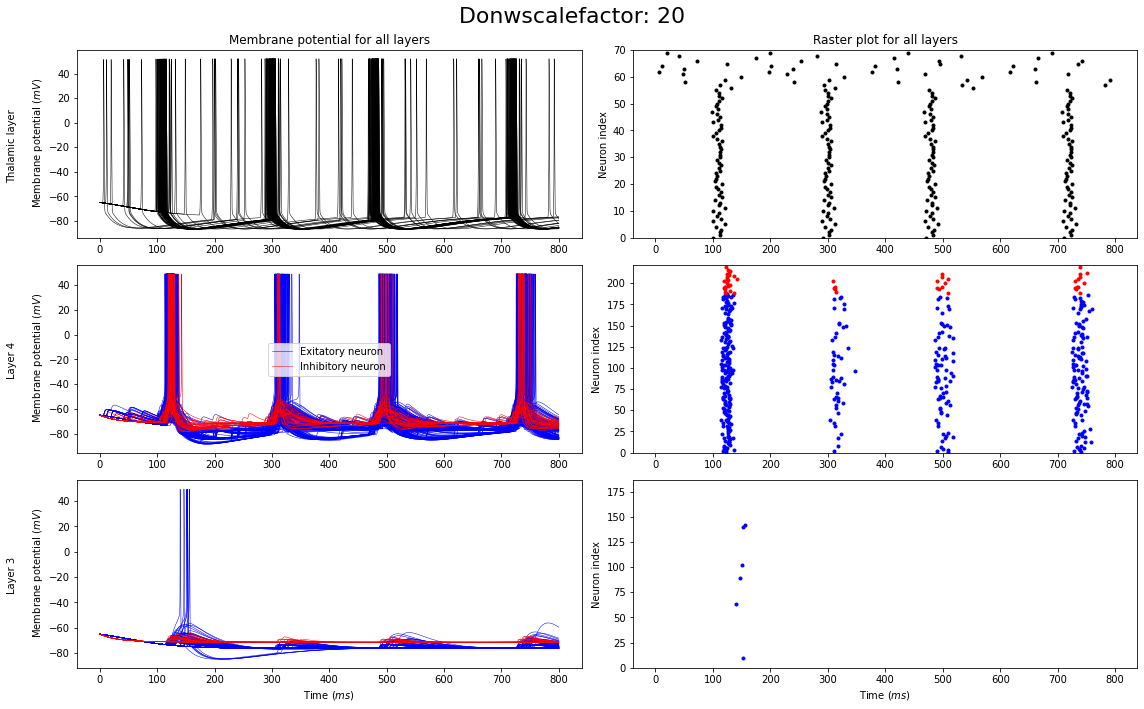

In [23]:
# Plotting the spikes
figure(figsize=(16, 10))

suptitle('Donwscalefactor: {}'.format(f_downscale), fontsize=22)

plt.subplot(321)
title('Membrane potential for all layers')
for neuron in range(0, num_thm):
    plot(statemon_thm_with_delays.t/ms, statemon_thm_with_delays.v[neuron]/mV,  c='k', linewidth = 0.5)
ylabel('Thalamic layer \n\n Membrane potential ($mV$)')

plt.subplot(322)
# mark the first and last time point so the axes align
time_p = np.arange(0, (simulation_duration)/ms)
plt.scatter(time_p[-1], 5, c='w')
plt.scatter(time_p[0], 5, c='w')
ylim(0, num_thm)
title('Raster plot for all layers')
data_thm = spikemon_thm_with_delays.spike_trains()
neurons = np.arange(0, num_thm)
for neuron in range(num_thm):
    for spike in range(len(data_thm[neuron])):
        plt.scatter(data_thm[neuron][spike]/ms, neuron, c='k', marker='.')
ylabel('Neuron index')

plt.subplot(323)
plot(M_E_L4_with_delays.t/ms, M_E_L4_with_delays.v[0]/mV, label='Exitatory neuron',  c='b', linewidth = 0.5) #plot the first ones seperately for the legend
plot(M_I_L4_with_delays.t/ms, M_I_L4_with_delays.v[0]/mV, label='Inhibitory neuron', c='r', linewidth = 0.5)
for neuron in range(1, N_E_L4):
    plot(M_E_L4_with_delays.t/ms, M_E_L4_with_delays.v[neuron]/mV,  c='b', linewidth = 0.5)
for neuron in range(1, N_I_L4):
    plot(M_I_L4_with_delays.t/ms, M_I_L4_with_delays.v[neuron]/mV, c='r', linewidth = 0.5)
ylabel('Layer 4 \n\n Membrane potential ($mV$)')
#legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
legend()

plt.subplot(324)
time = np.arange(0, (simulation_duration)/ms)
plt.scatter(time_p[-1], 5, c='w')
plt.scatter(time_p[0], 5, c='w')
ylim(0, N_L4)
dataE = spikemon_E_L4_with_delays.spike_trains()
dataI = spikemon_I_L4_with_delays.spike_trains()
neurons = np.arange(0, N_E_L4)
for neuron in range(N_E_L4):
    for spike in range(len(dataE[neuron])):
        plt.scatter(dataE[neuron][spike]/ms, neuron, c='b', marker='.')
for neuron in range(N_I_L4):
    for spike in range(len(dataI[neuron])):
        plt.scatter(dataI[neuron][spike]/ms, neuron+N_E_L4, c='r', marker='.')
ylabel('Neuron index')


plt.subplot(325)
#title('L3')
for neuron in range(0, N_E_L3):
    plot(M_E_L3_with_delays.t/ms, M_E_L3_with_delays.v[neuron]/mV,  c='b', linewidth = 0.5)
for neuron in range(0, N_I_L3):
    plot(M_I_L3_with_delays.t/ms, M_I_L3_with_delays.v[neuron]/mV, c='r', linewidth = 0.5) 
ylabel('Layer 3 \n\n Membrane potential ($mV$)')
xlabel('Time ($ms$)')


plt.subplot(326)
plt.scatter(time_p[-1], 5, c='w')
plt.scatter(time_p[0], 5, c='w')
ylim(0, N_L3)
dataE = spikemon_E_L3_with_delays.spike_trains()
dataI = spikemon_I_L3_with_delays.spike_trains()
neurons = np.arange(0, N_E_L3)
for neuron in range(N_E_L3):
    for spike in range(len(dataE[neuron])):
        plt.scatter(dataE[neuron][spike]/ms, neuron, c='b', marker='.')
for neuron in range(N_I_L3):
    for spike in range(len(dataI[neuron])):
        plt.scatter(dataI[neuron][spike]/ms, neuron+N_E_L3, c='r', marker='.')     
xlabel('Time ($ms$)')  
ylabel('Neuron index')


plt.tight_layout()
plt.show()

As can be seen, the inhibition in layer 4 starts at about the same time as excitation, so the delay should be even larger to allow more excitation.